In [1]:
 #accessing netcdf files from Hector's folders
import os, glob, sys
sys.path.append("//nobackup//amondal//Python//Hector_Python_Scripts")
sys.path.append("//nobackup//amondal//Python//mit_geos_analysis")
sys.path.append("//nobackup//amondal//Python//Hector_Python_Scripts//HandleMITgcm")
#from mds_store import openmdsdataset
#playing with netcdf - xarray
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
# How about visualization?
%matplotlib inline
import netCDF4
from netCDF4 import Dataset
#from xmitgcm import open_mdsdataset
from GetNCDataSet import *
from MITllc2160Depth import *



import xgcm
from spectral_analysis_code import *

from xmitgcm import open_mdsdataset
from dask.distributed import Client
client = Client(memory_limit='100GB',n_workers = 40, threads_per_worker=1)

Hector's parameters:



In [2]:
npdir = "/nobackup/amondal/NCData/Hector_CCS_Kappa/"
kpphbl = np.load(npdir + 'KPPhbl_test.npy')

In [3]:
kpphbl = kpphbl[:,:,0:600]

In [4]:
kpphbl.shape

(24, 786, 600)

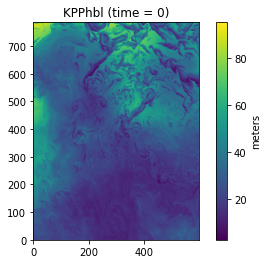

In [5]:
%matplotlib inline
plt.imshow(kpphbl[0,:,0:600])
plt.gca().invert_yaxis()
plt.title('KPPhbl (time = 0)')
cbar = plt.colorbar()
cbar.set_label('meters', rotation=90)

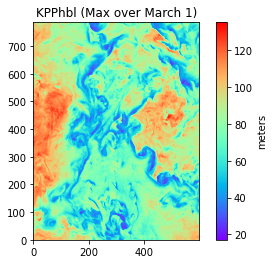

In [6]:
%matplotlib inline
kpphbl_max = np.amax(kpphbl, axis=0)
plt.imshow(kpphbl_max[:,0:600], cmap='rainbow')
plt.gca().invert_yaxis()
plt.title('KPPhbl (Max over March 1)')
cbar = plt.colorbar()
cbar.set_label('meters', rotation=90)

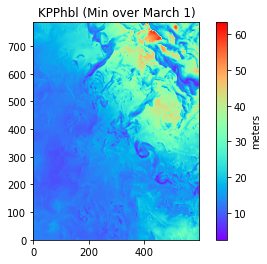

In [7]:
%matplotlib inline
kpphbl_min = np.amin(kpphbl, axis=0)
plt.imshow(kpphbl_min[:,0:600], cmap='rainbow')
plt.gca().invert_yaxis()
plt.title('KPPhbl (Min over March 1)')
cbar = plt.colorbar()
cbar.set_label('meters', rotation=90)

In [8]:
npdir = "/nobackup/amondal/NCData/Hector_CCS_Kappa/"
kppdt= np.load(npdir + 'KPPdiffT_test.npy')
max_depth = kppdt.shape[1]

In [9]:
kppdt = kppdt[:,:,:, 0:600]

In [10]:
kppdt.shape

(24, 30, 786, 600)

In [11]:
max_depth

30

Details about this regional simulation:

nx = 2400
ny = 2400

lat_range = 36,39
lon_range = -127.6, -122.5

I've had to restrict the longitude to ignore nans.

California current system

First thing we want to do is look at a few snapshots and try to identify some profiles 

so I'm defining Kappa_norm below, which is defined as $\frac{K_x}{h}$ where $h$ is the height defined by kpphbl.

So Large et al is a bit of a mess but I think we can begin with the assumption that $G(\sigma) = \sigma(1 - \sigma)^2$. We'll have Dimitris find the exact coefficients later. 

In [12]:
def shape_func(sigma):
    return sigma*(1 - sigma)**2

In [13]:
Kappa_norm = np.swapaxes(( np.swapaxes(kppdt,0,1) / kpphbl ),0,1)

In [14]:
Kappa_norm.shape

(24, 30, 786, 600)

It'll be convenient to use xarray and get heights in here for plotting.

In [15]:
thk = scipy.io.loadmat('../Hector_Python_Scripts/thk90')
thickness = thk['thk90'][0,0:90]
depth = thk['dpt90'][0,0:90]

In [16]:
depth_concat = depth[0:max_depth]

In [17]:
depth_concat

array([  0.5  ,   1.57 ,   2.79 ,   4.185,   5.78 ,   7.595,   9.66 ,
        12.01 ,  14.68 ,  17.705,  21.125,  24.99 ,  29.345,  34.24 ,
        39.725,  45.855,  52.69 ,  60.28 ,  68.685,  77.965,  88.175,
        99.37 , 111.6  , 124.915, 139.365, 154.99 , 171.825, 189.9  ,
       209.235, 229.855])

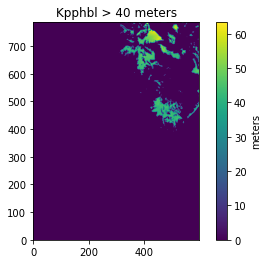

In [18]:
deep_places = np.where(kpphbl_min > 40, kpphbl_min,  0)
%matplotlib inline
plt.imshow(deep_places[:,0:600])
plt.gca().invert_yaxis()
plt.title('Kpphbl > 40 meters')
cbar = plt.colorbar()
cbar.set_label('meters', rotation=90)

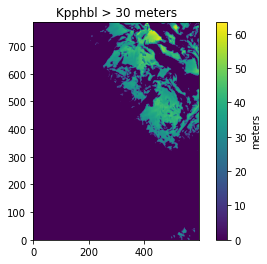

In [19]:
deep_places = np.where(kpphbl_min > 30, kpphbl_min,  0)
%matplotlib inline
plt.imshow(deep_places[:,0:600])
plt.gca().invert_yaxis()
plt.title('Kpphbl > 30 meters')
cbar = plt.colorbar()
cbar.set_label('meters', rotation=90)

In [20]:
deep_places[710,420]

42.77502

In [21]:
deep_places[730, 420]

49.628365

In [22]:
deep_places[751,437]

63.334682

In [23]:
max_di = np.argwhere(deep_places[:, 0:600] == np.max(deep_places[:, 0:600]))

In [24]:
max_di

array([[751, 437]])

Okay, so there's 3 places.
751,437
730,420
710,420

In [25]:
Kappa_norm.shape

(24, 30, 786, 600)

In [26]:
max_d_profile = Kappa_norm[12, :,max_di[0,0], max_di[0,1]]
max_d_kpphbl = kpphbl[12,max_di[0,0], max_di[0,1]]

Text(0.5, 1.0, 'Kappa Profiles: Max Depth ')

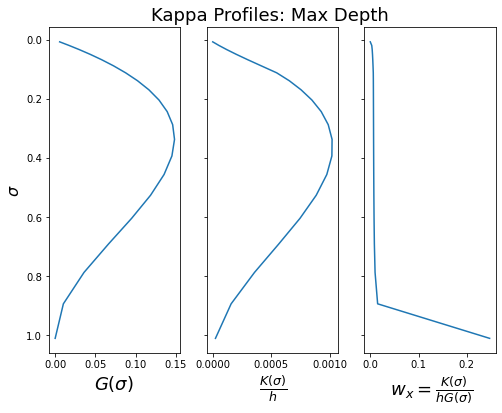

In [27]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(8,6))
#set up subplots

#define sigma and cut off plots where sigma = 1
max_d_sigma = depth_concat / max_d_kpphbl 
max_d_sigma_in = np.argwhere(max_d_sigma > 1)

#this plots kappa normalized just by kpphbl
ax2.plot(max_d_profile[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
plt.gca().invert_yaxis()
ax1.set_ylabel("$\sigma$", size = 16)
ax2.set_xlabel(r" $\frac{K(\sigma)}{h}$ ", size = 18)


# this plots the kappa normalized by kpphbl and G
max_d_sigma = depth_concat / max_d_kpphbl 
max_d_sigma_in = np.argwhere(max_d_sigma > 1)
max_d_G_sigma = shape_func(max_d_sigma)
max_d_profile_div_G = max_d_profile / max_d_G_sigma
ax3.plot(max_d_profile_div_G[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
#ax3.set_ylabel("$\sigma$", size = 16)
ax3.set_xlabel(r" $w_x = \frac{K(\sigma)}{h G(\sigma)}$ ", size = 18)


# this plots G - the shape function
ax1.plot(max_d_G_sigma[0:max_d_sigma_in[1,0]]  , max_d_sigma[0:max_d_sigma_in[1,0]])
ax1.set_xlabel(r"$G(\sigma)$ ", size = 18)

ax2.set_title("Kappa Profiles: Max Depth ",size=18)

So now, I need to define $u^*$ somehow. The tricky thing is that it's defined as: $ u^* = \bigg( \overline{w u_0}^2+  \overline{w v_0}^2 \bigg)$. What if $w=0$ at the surface? Wouldn't it be $0$ at the surface?

Let's study $w$ first.

In [28]:
npdir = "/nobackup/amondal/NCData/Hector_CCS_Kappa/"
w = np.load(npdir + 'W_test.npy')
u = np.load(npdir + 'U_test.npy')
v = np.load(npdir + 'V_test.npy')

In [29]:
t = np.load(npdir + 'T_test.npy')
taux = np.load(npdir + 'Taux_test.npy')
tauy = np.load(npdir + 'Tauy_test.npy')

In [30]:
taux = taux[:,:,0:600]
tauy = tauy[:,:,0:600]
t = t[:,:,:,0:600]

In [31]:
taux.shape
#axis 0 = time
#axis 1 = layers
#axis 2 = longitude
#axis 3 = latitude

(24, 786, 600)

So by inspection, these values of w seem quite small. But they are small throughout the 30 layers I have looked at which should be approximately the extent of the mixed layer (230m? - could be worth checking)

So for $u^* = \bigg( \overline{w u_0}^2+  \overline{w v_0}^2 \bigg)$ I'm assuming that w here is a function of z but with u and v we only take the surface layer (or the mean in space?) Maybe sticking with the surface is the safest thing.

Large detrends only in time presumably (that seems to be the default in the field).

In [32]:
#looking at U and V
v[0,:,max_di[0,0], max_di[0,1]]

array([0.0525601 , 0.0529201 , 0.05467483, 0.05710217, 0.06007065,
       0.06354119, 0.06751203, 0.07197656, 0.07688489, 0.08211417,
       0.08744389, 0.0925309 , 0.09688279, 0.09994347, 0.10126336,
       0.10076152, 0.09883303, 0.09618071, 0.09337967, 0.0923769 ,
       0.0966732 , 0.11416115, 0.11785479, 0.09111899, 0.05754014,
       0.06856805, 0.10123756, 0.11264639, 0.1116213 , 0.10364702])

In [33]:
from scipy import signal
#so I'm detrending only in time because that's what the paper suggests
u0p = signal.detrend(u[:,0,:,0:600],axis=0,type='linear')
v0p = signal.detrend(v[:,0,:,0:600],axis=0,type='linear')
wp = signal.detrend(w[:,:,:,0:600],axis=0,type='linear')

In [34]:
wpup = np.swapaxes(np.swapaxes(wp,0,1)*u0p,0,1)
#swap shenanigans - one swap to make multiplication work and then a swap back to remain consistent with axes

In [35]:
wpvp = np.swapaxes(np.swapaxes(wp,0,1)*v0p, 0,1)

In [36]:
wpup_bar = np.mean(wpup, axis=0)
wpvp_bar = np.mean(wpvp, axis=0)

In [37]:
ustar = np.sqrt(np.sqrt(wpup_bar**2 + wpvp_bar**2))

In [38]:
ustar.shape

(30, 786, 600)

In [39]:
rho_0 = 1027.5 #kg/m^3
ustar_wind = np.sqrt((taux / rho_0)**2 + (tauy / rho_0)**2)

In [40]:
max_d_profile = Kappa_norm[12, :,max_di[0,0], max_di[0,1]]
max_d_kpphbl = kpphbl[12,max_di[0,0], max_di[0,1]]
ustar_snapshot = ustar_wind[12,max_di[0,0], max_di[0,1]]#ustar[:,max_di[0,0], max_di[0,1]]
#this corresponds to 12 hours in (since we've averaged over a day)
von_karman = 0.4

In [41]:
ustar_snapshot

0.00012022931

I think we can normalize plots now!

(-1.0, 1000.0)

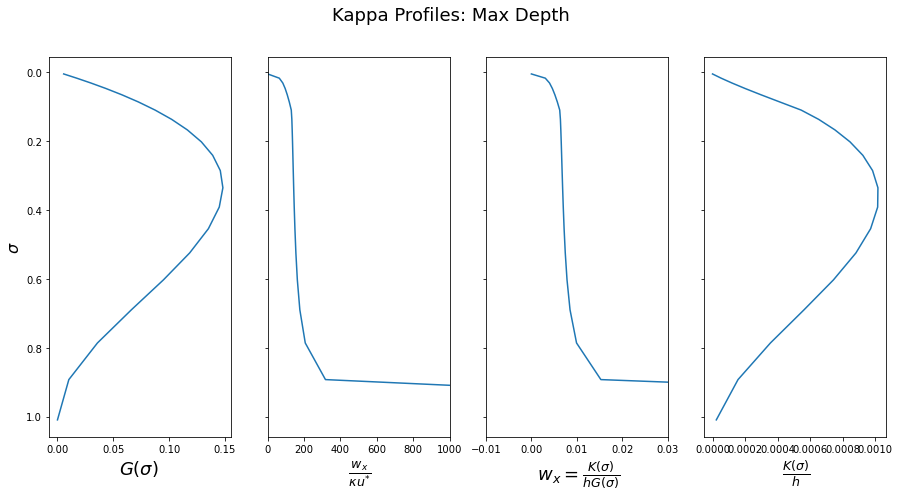

In [42]:
%matplotlib inline
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharey=True, figsize=(15,7))
#set up subplots

#define sigma and cut off plots where sigma = 1
max_d_sigma = depth_concat / max_d_kpphbl 
max_d_sigma_in = np.argwhere(max_d_sigma > 1)

#this plots kappa normalized just by kpphbl
ax4.plot(max_d_profile[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
plt.gca().invert_yaxis()
ax1.set_ylabel("$\sigma$", size = 16)
ax4.set_xlabel(r" $\frac{K(\sigma)}{h}$ ", size = 18)


# this plots the kappa normalized by kpphbl and G
max_d_sigma = depth_concat / max_d_kpphbl 
max_d_sigma_in = np.argwhere(max_d_sigma > 1)
max_d_G_sigma = shape_func(max_d_sigma)
max_d_profile_div_G = max_d_profile / max_d_G_sigma
ax3.plot(max_d_profile_div_G[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
#ax3.set_ylabel("$\sigma$", size = 16)
ax3.set_xlabel(r" $w_x = \frac{K(\sigma)}{h G(\sigma)}$ ", size = 18)
ax3.set_xlim([-0.01,0.03])

# this plots G - the shape function
ax1.plot(max_d_G_sigma[0:max_d_sigma_in[1,0]]  , max_d_sigma[0:max_d_sigma_in[1,0]])
ax1.set_xlabel(r"$G(\sigma)$ ", size = 18)

plt.suptitle("Kappa Profiles: Max Depth ",size=18)


#now, I'll plot w / (kpphbl*G*vonkarman*ustar)
max_d_profile_wx = max_d_profile / max_d_G_sigma / ustar_snapshot / von_karman
ax2.plot(max_d_profile_wx[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
#ax3.set_ylabel("$\sigma$", size = 16)
ax2.set_xlabel(r" $\frac{w_x}{\kappa u^{*}}$ ", size = 18)
ax2.set_xlim([-1,1000])

# I also want to take a look at ustar
#ax5.plot(ustar_snapshot[0:max_d_sigma_in[1,0]], max_d_sigma[0:max_d_sigma_in[1,0]])
#ax5.set_xlabel(r" $u^*$", size=18)



In [43]:
lat = 730
lon = 420
max_d_profile = Kappa_norm[12, :,lat, lon]
max_d_kpphbl = kpphbl[12,lat, lon]

#ustar_snapshot = ustar[:,lat, lon]
ustar_snapshot = ustar_wind[12,lat,lon]
#this corresponds to 12 hours in (since we've averaged over a day)
von_karman = 0.4

(-1.0, 1000.0)

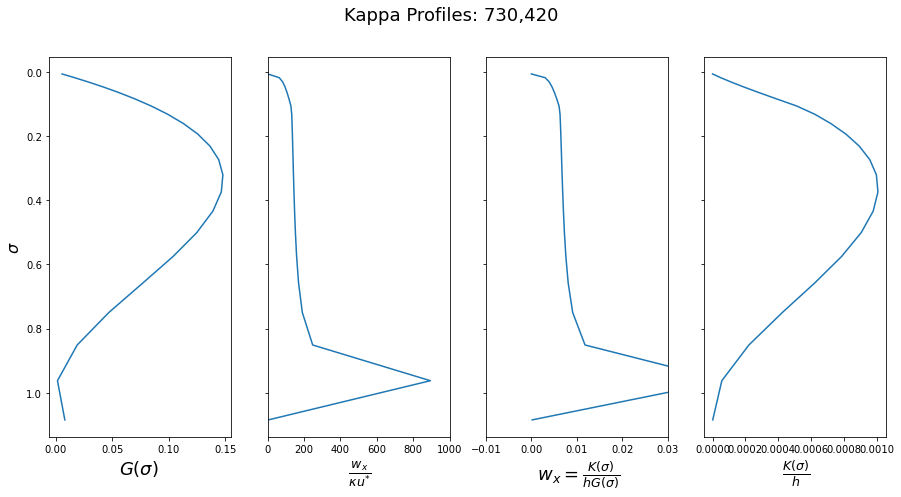

In [44]:
%matplotlib inline
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharey=True, figsize=(15,7))
#set up subplots

#define sigma and cut off plots where sigma = 1
max_d_sigma = depth_concat / max_d_kpphbl 
max_d_sigma_in = np.argwhere(max_d_sigma > 1)

#this plots kappa normalized just by kpphbl
ax4.plot(max_d_profile[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
plt.gca().invert_yaxis()
ax1.set_ylabel("$\sigma$", size = 16)
ax4.set_xlabel(r" $\frac{K(\sigma)}{h}$ ", size = 18)


# this plots the kappa normalized by kpphbl and G
max_d_sigma = depth_concat / max_d_kpphbl 
max_d_sigma_in = np.argwhere(max_d_sigma > 1)
max_d_G_sigma = shape_func(max_d_sigma)
max_d_profile_div_G = max_d_profile / max_d_G_sigma
ax3.plot(max_d_profile_div_G[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
#ax3.set_ylabel("$\sigma$", size = 16)
ax3.set_xlabel(r" $w_x = \frac{K(\sigma)}{h G(\sigma)}$ ", size = 18)
ax3.set_xlim([-0.01,0.03])

# this plots G - the shape function
ax1.plot(max_d_G_sigma[0:max_d_sigma_in[1,0]]  , max_d_sigma[0:max_d_sigma_in[1,0]])
ax1.set_xlabel(r"$G(\sigma)$ ", size = 18)

plt.suptitle("Kappa Profiles: 730,420 ",size=18)


#now, I'll plot w / (kpphbl*G*vonkarman*ustar)
max_d_profile_wx = max_d_profile / max_d_G_sigma / ustar_snapshot / von_karman
ax2.plot(max_d_profile_wx[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
#ax3.set_ylabel("$\sigma$", size = 16)
ax2.set_xlabel(r" $\frac{w_x}{\kappa u^{*}}$ ", size = 18)
ax2.set_xlim([-1,1000])

# I also want to take a look at ustar
#ax5.plot(ustar_snapshot[0:max_d_sigma_in[1,0]], max_d_sigma[0:max_d_sigma_in[1,0]])
#ax5.set_xlabel(r" $u^*$", size=18)



In [45]:
lat = 710
lon = 420
max_d_profile = Kappa_norm[12, :,lat, lon]
max_d_kpphbl = kpphbl[12,lat, lon]

ustar_snapshot = ustar_wind[12,lat,lon]
#this corresponds to 12 hours in (since we've averaged over a day)
von_karman = 0.4

(0.0, 400.0)

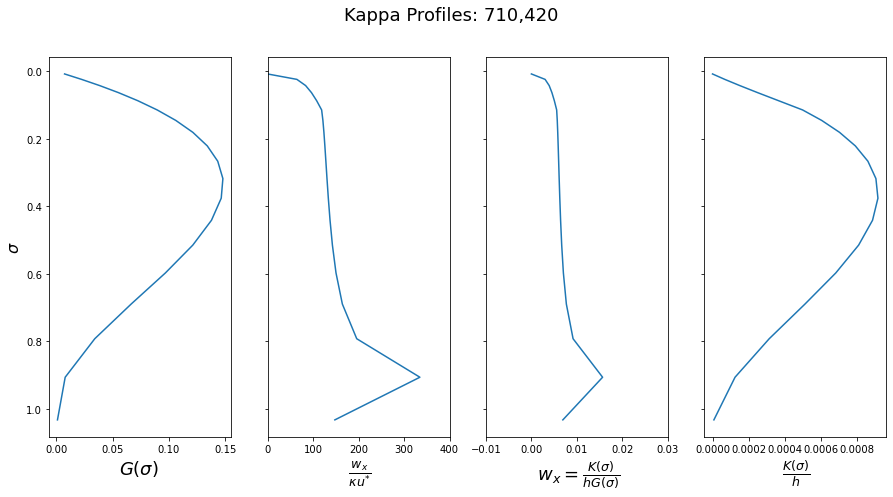

In [46]:
%matplotlib inline
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharey=True, figsize=(15,7))
#set up subplots

#define sigma and cut off plots where sigma = 1
max_d_sigma = depth_concat / max_d_kpphbl 
max_d_sigma_in = np.argwhere(max_d_sigma > 1)

#this plots kappa normalized just by kpphbl
ax4.plot(max_d_profile[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
plt.gca().invert_yaxis()
ax1.set_ylabel("$\sigma$", size = 16)
ax4.set_xlabel(r" $\frac{K(\sigma)}{h}$ ", size = 18)


# this plots the kappa normalized by kpphbl and G
max_d_sigma = depth_concat / max_d_kpphbl 
max_d_sigma_in = np.argwhere(max_d_sigma > 1)
max_d_G_sigma = shape_func(max_d_sigma)
max_d_profile_div_G = max_d_profile / max_d_G_sigma
ax3.plot(max_d_profile_div_G[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
#ax3.set_ylabel("$\sigma$", size = 16)
ax3.set_xlabel(r" $w_x = \frac{K(\sigma)}{h G(\sigma)}$ ", size = 18)
ax3.set_xlim([-0.01,0.03])

# this plots G - the shape function
ax1.plot(max_d_G_sigma[0:max_d_sigma_in[1,0]]  , max_d_sigma[0:max_d_sigma_in[1,0]])
ax1.set_xlabel(r"$G(\sigma)$ ", size = 18)

plt.suptitle("Kappa Profiles: 710,420 ",size=18)


#now, I'll plot w / (kpphbl*G*vonkarman*ustar)
max_d_profile_wx = max_d_profile / max_d_G_sigma / ustar_snapshot / von_karman
ax2.plot(max_d_profile_wx[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
#ax3.set_ylabel("$\sigma$", size = 16)
ax2.set_xlabel(r" $\frac{w_x}{\kappa u^{*}}$ ", size = 18)
ax2.set_xlim([0,400])

# I also want to take a look at ustar
#ax5.plot(ustar_snapshot[0:max_d_sigma_in[1,0]], max_d_sigma[0:max_d_sigma_in[1,0]])
#ax5.set_xlabel(r" $u^*$", size=18)


In [47]:
lat = 40
lon = 420
max_d_profile = Kappa_norm[12, :,lat, lon]
max_d_kpphbl = kpphbl[12,lat, lon]

ustar_snapshot = ustar_wind[12,lat, lon]
#this corresponds to 12 hours in (since we've averaged over a day)
von_karman = 0.4

(0.0, 700.0)

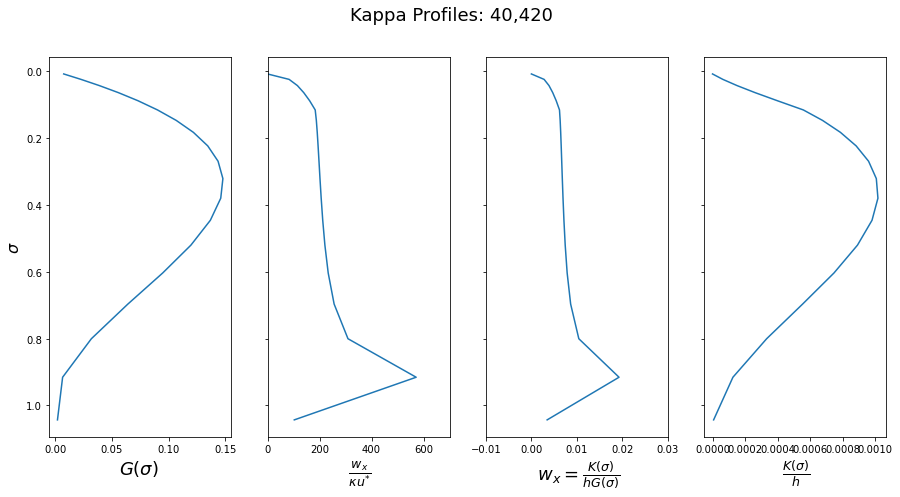

In [48]:
%matplotlib inline
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharey=True, figsize=(15,7))
#set up subplots

#define sigma and cut off plots where sigma = 1
max_d_sigma = depth_concat / max_d_kpphbl 
max_d_sigma_in = np.argwhere(max_d_sigma > 1)

#this plots kappa normalized just by kpphbl
ax4.plot(max_d_profile[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
plt.gca().invert_yaxis()
ax1.set_ylabel("$\sigma$", size = 16)
ax4.set_xlabel(r" $\frac{K(\sigma)}{h}$ ", size = 18)


# this plots the kappa normalized by kpphbl and G
max_d_sigma = depth_concat / max_d_kpphbl 
max_d_sigma_in = np.argwhere(max_d_sigma > 1)
max_d_G_sigma = shape_func(max_d_sigma)
max_d_profile_div_G = max_d_profile / max_d_G_sigma
ax3.plot(max_d_profile_div_G[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
#ax3.set_ylabel("$\sigma$", size = 16)
ax3.set_xlabel(r" $w_x = \frac{K(\sigma)}{h G(\sigma)}$ ", size = 18)
ax3.set_xlim([-0.01,0.03])

# this plots G - the shape function
ax1.plot(max_d_G_sigma[0:max_d_sigma_in[1,0]]  , max_d_sigma[0:max_d_sigma_in[1,0]])
ax1.set_xlabel(r"$G(\sigma)$ ", size = 18)

plt.suptitle("Kappa Profiles: 40,420 ",size=18)


#now, I'll plot w / (kpphbl*G*vonkarman*ustar)
max_d_profile_wx = max_d_profile / max_d_G_sigma / ustar_snapshot / von_karman
ax2.plot(max_d_profile_wx[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
#ax3.set_ylabel("$\sigma$", size = 16)
ax2.set_xlabel(r" $\frac{w_x}{\kappa u^{*}}$ ", size = 18)
ax2.set_xlim([0,700])

# I also want to take a look at ustar
#ax5.plot(ustar_snapshot[0:max_d_sigma_in[1,0]], max_d_sigma[0:max_d_sigma_in[1,0]])
#ax5.set_xlabel(r" $u^*$", size=18)


In [49]:
lat = 40
lon = 40
max_d_profile = Kappa_norm[12, :,lat, lon]
max_d_kpphbl = kpphbl[12,lat, lon]

ustar_snapshot = ustar_wind[12,lat, lon]
#this corresponds to 12 hours in (since we've averaged over a day)
von_karman = 0.4

(0.0, 3000.0)

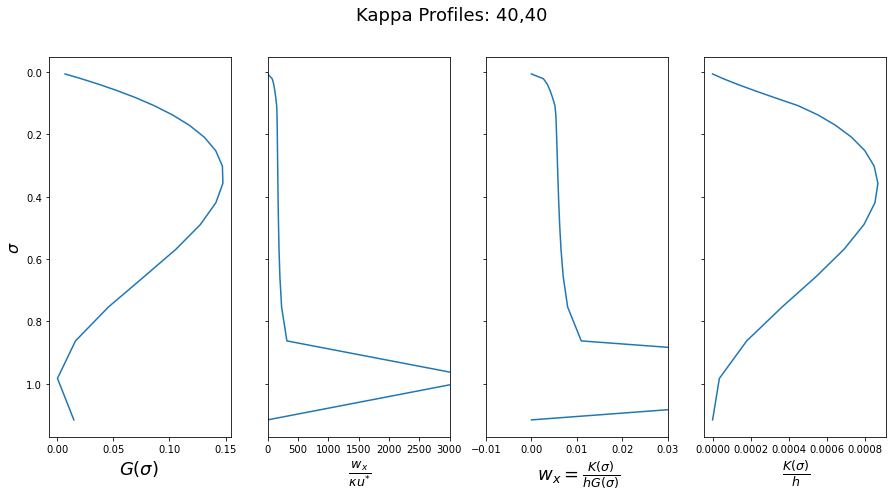

In [50]:
%matplotlib inline
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharey=True, figsize=(15,7))
#set up subplots

#define sigma and cut off plots where sigma = 1
max_d_sigma = depth_concat / max_d_kpphbl 
max_d_sigma_in = np.argwhere(max_d_sigma > 1)

#this plots kappa normalized just by kpphbl
ax4.plot(max_d_profile[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
plt.gca().invert_yaxis()
ax1.set_ylabel("$\sigma$", size = 16)
ax4.set_xlabel(r" $\frac{K(\sigma)}{h}$ ", size = 18)


# this plots the kappa normalized by kpphbl and G
max_d_sigma = depth_concat / max_d_kpphbl 
max_d_sigma_in = np.argwhere(max_d_sigma > 1)
max_d_G_sigma = shape_func(max_d_sigma)
max_d_profile_div_G = max_d_profile / max_d_G_sigma
ax3.plot(max_d_profile_div_G[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
#ax3.set_ylabel("$\sigma$", size = 16)
ax3.set_xlabel(r" $w_x = \frac{K(\sigma)}{h G(\sigma)}$ ", size = 18)
ax3.set_xlim([-0.01,0.03])

# this plots G - the shape function
ax1.plot(max_d_G_sigma[0:max_d_sigma_in[1,0]]  , max_d_sigma[0:max_d_sigma_in[1,0]])
ax1.set_xlabel(r"$G(\sigma)$ ", size = 18)

plt.suptitle("Kappa Profiles: 40,40 ",size=18)


#now, I'll plot w / (kpphbl*G*vonkarman*ustar)
max_d_profile_wx = max_d_profile / max_d_G_sigma / ustar_snapshot / von_karman
ax2.plot(max_d_profile_wx[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
#ax3.set_ylabel("$\sigma$", size = 16)
ax2.set_xlabel(r" $\frac{w_x}{\kappa u^{*}}$ ", size = 18)
ax2.set_xlim([0,3000])

# I also want to take a look at ustar
#ax5.plot(ustar_snapshot[0:max_d_sigma_in[1,0]], max_d_sigma[0:max_d_sigma_in[1,0]])
#ax5.set_xlabel(r" $u^*$", size=18)


In [51]:
lat = 40
lon = 200
max_d_profile = Kappa_norm[12, :,lat, lon]
max_d_kpphbl = kpphbl[12,lat, lon]

ustar_snapshot = ustar_wind[12,lat, lon]
#this corresponds to 12 hours in (since we've averaged over a day)
von_karman = 0.4

(0.0, 1000.0)

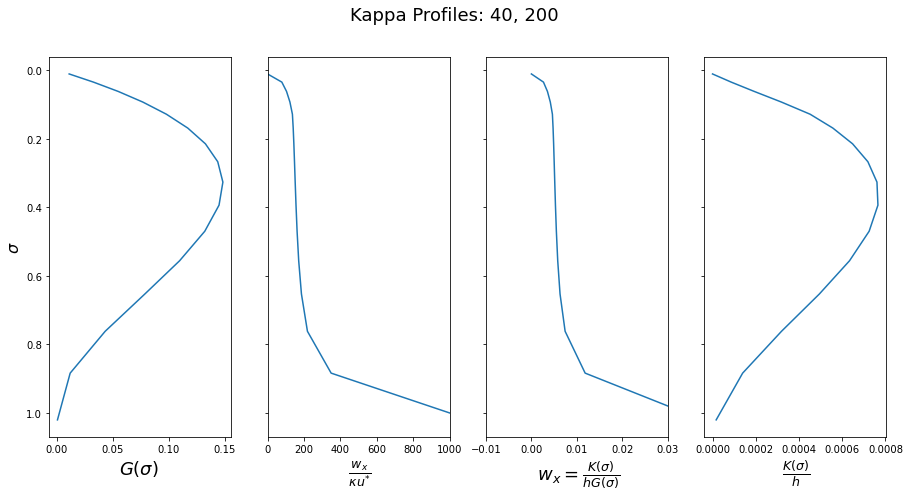

In [52]:
%matplotlib inline
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharey=True, figsize=(15,7))
#set up subplots

#define sigma and cut off plots where sigma = 1
max_d_sigma = depth_concat / max_d_kpphbl 
max_d_sigma_in = np.argwhere(max_d_sigma > 1)

#this plots kappa normalized just by kpphbl
ax4.plot(max_d_profile[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
plt.gca().invert_yaxis()
ax1.set_ylabel("$\sigma$", size = 16)
ax4.set_xlabel(r" $\frac{K(\sigma)}{h}$ ", size = 18)


# this plots the kappa normalized by kpphbl and G
max_d_sigma = depth_concat / max_d_kpphbl 
max_d_sigma_in = np.argwhere(max_d_sigma > 1)
max_d_G_sigma = shape_func(max_d_sigma)
max_d_profile_div_G = max_d_profile / max_d_G_sigma
ax3.plot(max_d_profile_div_G[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
#ax3.set_ylabel("$\sigma$", size = 16)
ax3.set_xlabel(r" $w_x = \frac{K(\sigma)}{h G(\sigma)}$ ", size = 18)
ax3.set_xlim([-0.01,0.03])

# this plots G - the shape function
ax1.plot(max_d_G_sigma[0:max_d_sigma_in[1,0]]  , max_d_sigma[0:max_d_sigma_in[1,0]])
ax1.set_xlabel(r"$G(\sigma)$ ", size = 18)

plt.suptitle("Kappa Profiles: 40, 200",size=18)


#now, I'll plot w / (kpphbl*G*vonkarman*ustar)
max_d_profile_wx = max_d_profile / max_d_G_sigma / ustar_snapshot / von_karman
ax2.plot(max_d_profile_wx[0:max_d_sigma_in[1,0]] , max_d_sigma[0:max_d_sigma_in[1,0]])
#ax3.set_ylabel("$\sigma$", size = 16)
ax2.set_xlabel(r" $\frac{w_x}{\kappa u^{*}}$ ", size = 18)
ax2.set_xlim([0,1000])

# I also want to take a look at ustar
#ax5.plot(ustar_snapshot[0:max_d_sigma_in[1,0]], max_d_sigma[0:max_d_sigma_in[1,0]])
#ax5.set_xlabel(r" $u^*$", size=18)


So one problem is that in Large et al, for $\frac{w}{k u^*}(\sigma=0) = 1$. But it's not really possible to back that out by
dividing out $G(\sigma)$ since $G(\sigma=0)=0$ as well.

I'm learning from Large et al some very crucial things:

1) For ice free conditions, $\overline{w u_0} = -\frac{\tau_x}{\rho_0}$, $\overline{w v_0} = -\frac{\tau_y}{\rho_0}$, which means $u^* = \bigg[\bigg(\frac{\tau_x}{\rho_0}\bigg)^2 + \bigg(\frac{\tau_y}{\rho_0}\bigg)^2\bigg]^{\frac{1}{2}}$. Does this imply that $u^*$ does not vary in depth for
the mixing layer. So $\overline{w u_0}$ = $\overline{w_0' u_0'}$ Or should I average over the kpphbl height first to define $u_0$. 

2) If you put together all the equations in Large et al: $K_x = -\frac{G(\sigma)}{\sigma} \cfrac{\overline{w t_0}}{\partial_z T}$. See lab notebook for details (or write them out here more fully). What makes this especially nice is that $\overline{w t_0} = -\frac{Q_t}{\rho_0 C_\rho}$, where $Q_t$ is turbulent heat fluxes. Again, for ice free conditions, $Q_t = Q_{lw} + Q_{lat}+Q_{sens}$ which may equal $Q_{net} - Q_{sw}$. Then, it may be possible to write

$K_x \partial_z T = - \frac{G(\sigma)}{\sigma} (Q_{net} - Q_{sw})$ which means that we would only really need to confirm $G(\sigma)$ to fully calculate $K_x$. But before I get ahead of myself, I should use $T$ to calculate $\frac{G(\sigma)}{\sigma}$.

--------------------------------------------------------------------------------------------------------------------------------------------------
Here, I'm trying to see what's going on below the mixed layer to see what diffusivities we should have.

In [53]:
npdir = "/nobackup/amondal/NCData/Hector_CCS_Kappa/"
kppvA= np.load(npdir + 'KPPviscA_test.npy')


In [54]:
npdir = "/nobackup/amondal/NCData/Hector_CCS_Kappa/"
kppdt= np.load(npdir + 'KPPdiffT_test.npy')

In [55]:
npdir = "/nobackup/amondal/NCData/Hector_CCS_Kappa/"
kpphbl = np.load(npdir + 'KPPhbl_test.npy')

In [56]:
kppvA.shape

(24, 30, 786, 980)

In [57]:
kppdt.shape

(24, 30, 786, 980)

In [58]:
depthToZlayer(np.nanmax(kpphbl))

24

In [59]:
zlayerToDepth(24)

139.365

In [60]:
kppdt_deep = kppdt[:,24:,:,:]

In [61]:
small_kppdt = np.where(kppdt_deep > 5e-3, 1,0 )

In [62]:
small_diff = small_kppdt.sum()

In [63]:
deep_size = small_kppdt.shape[0]*small_kppdt.shape[1]*small_kppdt.shape[2]*small_kppdt.shape[3]

In [64]:
small_diff / deep_size

0.00017864174932059337

In [65]:
kppvA_deep = kppvA[:,24:,:,:]
small_kppvA = np.where(kppvA_deep > 5e-3,1,0)
small_visc = small_kppvA.sum()

In [66]:
small_visc / deep_size

0.00042880330673405917

In [68]:
Qsw = getMITNCDataSet('/nobackup/amondal/NCData/Hector_CCS_Kappa/', 'oceQsw', 0,0 )

Time combined dataset has been opened.
I concatenated the first Z-layer


In [69]:
Qswc = Qsw.compute()

In [70]:
Qswc

<xarray.Dataset>
Dimensions:  (lat: 75, lon: 128, time: 96)
Coordinates:
  * lat      (lat) float64 36.0 36.04 36.08 36.12 ... 38.84 38.88 38.92 38.96
  * lon      (lon) float64 -127.6 -127.6 -127.5 -127.5 ... -122.6 -122.6 -122.5
  * time     (time) datetime64[ns] 2020-03-01 ... 2020-03-04T23:00:00
Data variables:
    oceQsw   (time, lat, lon) float64 -49.16 -50.83 -51.08 ... nan nan nan

In [71]:
npdir = "/nobackup/amondal/NCData/Hector_CCS_Kappa/"
latc = np.load(npdir + 'latc_test.npy')
lonc = np.load(npdir + 'lonc_test.npy')

In [72]:
latc.shape

(786, 980)

In [73]:
lonc.shape

(786, 980)

In [74]:
Qswc_interp = Qswc.interp(lat = latc[:,0], lon = lonc[0,:], method = 'linear',kwargs={"fill_value": "extrapolate"},)

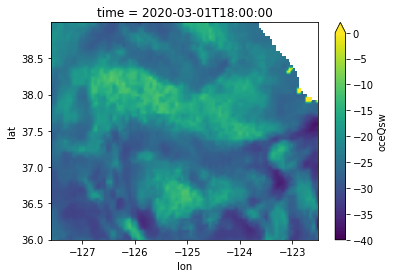

In [75]:
%matplotlib inline
Qswc_interp.oceQsw[18].plot(vmin=-40, vmax=0)

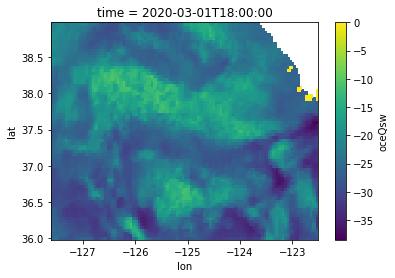

In [76]:
%matplotlib inline
Qswc.oceQsw[18].plot()

In [77]:
qswc_i = Qswc_interp.oceQsw

In [78]:
qswc_i.lat.size

786

In [79]:
qswc_i.to_netcdf('/nobackup/amondal/NCData/Hector_CCS_Kappa/Qsw_interp_CCS.nc')

In [80]:
qnet_np = np.load(npdir + 'Qnet_test.npy')

In [81]:
qnet = xr.DataArray(qnet_np, dims = ['time','lat','lon'], coords = [qswc_i.time[0:24], qswc_i.lat, qswc_i.lon],name="oceQnet" )

In [82]:
qswc_1day = qswc_i[0:24]

In [83]:
qswc_1day

<xarray.DataArray 'oceQsw' (time: 24, lat: 786, lon: 980)>
array([[[-49.10954109, -49.32312921, -49.53671734, ..., -47.84445089,
         -47.86014386, -47.87583684],
        [-49.06498932, -49.28825963, -49.51152994, ..., -47.81774568,
         -47.8351576 , -47.85256951],
        [-49.02043754, -49.25339005, -49.48634255, ..., -47.79104048,
         -47.81017133, -47.82930218],
        ...,
        [-46.83115828, -46.84516611, -46.85917394, ...,          nan,
                  nan,          nan],
        [-46.81865291, -46.83331076, -46.8479686 , ...,          nan,
                  nan,          nan],
        [-46.80614754, -46.8214554 , -46.83676327, ...,          nan,
                  nan,          nan]],

       [[-32.26500976, -32.43078495, -32.59656015, ..., -28.82019361,
         -28.8199655 , -28.81973738],
        [-32.2440726 , -32.41158422, -32.57909584, ..., -28.79119417,
         -28.78818584, -28.78517751],
        [-32.22313544, -32.39238349, -32.56163154, ..., -28.76219473,
         -28.75640619, -28.75061764],
...
        [-46.85296313, -46.80106982, -46.7491765 , ...,          nan,
                  nan,          nan],
        [-46.87857594, -46.81699471, -46.75541348, ...,          nan,
                  nan,          nan],
        [-46.90418875, -46.83291961, -46.76165047, ...,          nan,
                  nan,          nan]],

       [[-52.27005259, -52.10858303, -51.94711347, ..., -42.54792851,
         -42.72118354, -42.89443856],
        [-52.2535971 , -52.09607024, -51.93854338, ..., -42.6573688 ,
         -42.81157805, -42.9657873 ],
        [-52.23714161, -52.08355745, -51.92997329, ..., -42.76680908,
         -42.90197255, -43.03713603],
        ...,
        [-47.66791656, -47.31820576, -46.96849495, ...,          nan,
                  nan,          nan],
        [-47.8109421 , -47.4445778 , -47.07821351, ...,          nan,
                  nan,          nan],
        [-47.95396763, -47.57094985, -47.18793206, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2020-03-01 ... 2020-03-01T23:00:00
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5

In [84]:
qnet

<xarray.DataArray 'oceQnet' (time: 24, lat: 786, lon: 980)>
array([[[137.42088  , 139.2515   , 143.50304  , ...,  52.150776 ,
          51.85632  ,  51.49797  ],
        [140.15108  , 144.7061   , 151.42345  , ...,  52.076717 ,
          51.83509  ,  51.5868   ],
        [147.4982   , 152.7043   , 155.07828  , ...,  52.011086 ,
          51.869987 ,  51.678947 ],
        ...,
        [ 42.213863 ,  43.107563 ,  43.50372  , ...,         nan,
                 nan,         nan],
        [ 41.980877 ,  42.461517 ,  42.740288 , ...,         nan,
                 nan,         nan],
        [ 41.487427 ,  41.957886 ,  42.36011  , ...,         nan,
                 nan,         nan]],

       [[ 78.82987  ,  82.63438  ,  89.459724 , ...,  -1.8978671,
          -2.0692575,  -2.2001383],
        [ 84.965195 ,  89.948875 ,  93.65157  , ...,  -2.0243669,
          -2.1907053,  -2.2929003],
        [ 91.325775 ,  94.126434 ,  94.769325 , ...,  -2.153872 ,
          -2.2906518,  -2.2915437],
...
        [230.13171  , 230.00658  , 229.87698  , ...,         nan,
                 nan,         nan],
        [229.99425  , 229.76712  , 229.57607  , ...,         nan,
                 nan,         nan],
        [229.71715  , 229.5402   , 229.10521  , ...,         nan,
                 nan,         nan]],

       [[238.12714  , 237.84715  , 237.61844  , ...,  77.739204 ,
          76.93259  ,  75.39061  ],
        [237.614    , 237.33083  , 237.13995  , ...,  77.025314 ,
          76.6289   ,  75.89793  ],
        [237.15718  , 236.8536   , 236.66078  , ...,  75.87834  ,
          75.72399  ,  75.41241  ],
        ...,
        [160.1398   , 159.94812  , 159.84814  , ...,         nan,
                 nan,         nan],
        [160.13264  , 159.93282  , 159.73833  , ...,         nan,
                 nan,         nan],
        [160.0887   , 159.8894   , 159.188    , ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-03-01 ... 2020-03-01T23:00:00
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5

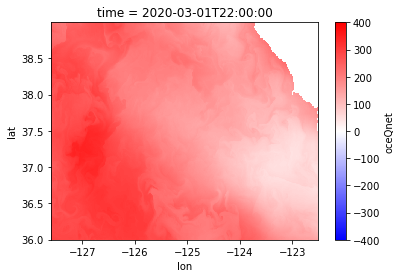

In [85]:
%matplotlib inline
qnet[22].plot(cmap='bwr', vmin=-400, vmax = 400)

I need to be able to create a function for $G(\sigma)$. But it has to vary in space. 

In [86]:
npdir = "/nobackup/amondal/NCData/Hector_CCS_Kappa/"
kpphbl = np.load(npdir + 'KPPhbl_test.npy')

In [87]:
Kpphbl = xr.DataArray(kpphbl, dims = ['time','lat','lon'], coords = [qswc_i.time[0:24], qswc_i.lat, qswc_i.lon],name="KPPhbl" )

In [88]:
Kpphbl

<xarray.DataArray 'KPPhbl' (time: 24, lat: 786, lon: 980)>
array([[[25.289835, 24.263832, 22.668718, ..., 61.79544 , 63.226135,
         63.69956 ],
        [23.811714, 22.459932, 21.0932  , ..., 61.70369 , 62.795708,
         63.76628 ],
        [21.987587, 21.054361, 20.764526, ..., 61.5795  , 62.563503,
         63.754074],
        ...,
        [94.35166 , 94.24466 , 94.25101 , ...,       nan,       nan,
               nan],
        [94.89973 , 94.89752 , 94.63494 , ...,       nan,       nan,
               nan],
        [95.387924, 94.89254 , 94.096466, ...,       nan,       nan,
               nan]],

       [[47.525146, 44.22515 , 39.089684, ..., 58.230236, 59.304432,
         60.317505],
        [42.80138 , 39.544823, 37.237026, ..., 58.494663, 58.3832  ,
         58.919693],
        [39.08055 , 37.49246 , 36.1215  , ..., 57.94847 , 57.349735,
         58.140587],
...
        [16.778471, 16.754484, 16.720547, ...,       nan,       nan,
               nan],
        [16.812098, 16.81435 , 16.773588, ...,       nan,       nan,
               nan],
        [16.899046, 16.87366 , 16.867567, ...,       nan,       nan,
               nan]],

       [[17.4625  , 17.493805, 17.488283, ..., 78.62664 , 71.91596 ,
         53.88944 ],
        [17.45629 , 17.509956, 17.476063, ..., 77.67126 , 75.854675,
         71.163124],
        [17.478539, 17.520645, 17.475323, ..., 73.464516, 72.75323 ,
         72.439674],
        ...,
        [24.271881, 24.278376, 24.19581 , ...,       nan,       nan,
               nan],
        [24.257565, 24.271442, 24.194044, ...,       nan,       nan,
               nan],
        [24.234205, 24.24459 , 24.316853, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-03-01 ... 2020-03-01T23:00:00
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5

 I want to develop a sigma matrix - something like getWeightedThicknessVector but simpler. Effectively a matrix that looks like a field sigma with dims depth, time, and space.

In [89]:
'time' in Kpphbl.dims

True

In [90]:
npdir = "/nobackup/amondal/NCData/Hector_CCS_Kappa/"
kpphbl = np.load(npdir + 'KPPhbl_test.npy')
Kpphbl = xr.DataArray(kpphbl, dims = ['time','lat','lon'], coords = [qswc_i.time[0:24], qswc_i.lat, qswc_i.lon],name="KPPhbl" )
Nlayers = 30
layer = xr.full_like(Kpphbl, zlayerToDepth(0))
sigma = layer / Kpphbl
sigma.expand_dims(dim='depth', axis=1)
for i in range(1, Nlayers):
    layer = xr.full_like(Kpphbl, zlayerToDepth(i))
    sigma_add = layer / Kpphbl
    sigma = xr.concat((sigma,sigma_add),dim='depth')
sigma = sigma.rename(r'$\sigma$')    
sigma.assign_coords({'depth':zlayerToDepth(np.arange(0,Nlayers))})

<xarray.DataArray '$\\sigma$' (depth: 30, time: 24, lat: 786, lon: 980)>
array([[[[1.97707899e-02, 2.06068028e-02, 2.20568273e-02, ...,
          8.09121225e-03, 7.90812168e-03, 7.84934778e-03],
         [2.09980682e-02, 2.22618654e-02, 2.37043202e-02, ...,
          8.10324308e-03, 7.96232745e-03, 7.84113444e-03],
         [2.27401033e-02, 2.37480495e-02, 2.40795277e-02, ...,
          8.11958592e-03, 7.99188018e-03, 7.84263574e-03],
         ...,
         [5.29932370e-03, 5.30534051e-03, 5.30498289e-03, ...,
                     nan,            nan,            nan],
         [5.26871905e-03, 5.26884152e-03, 5.28346095e-03, ...,
                     nan,            nan,            nan],
         [5.24175353e-03, 5.26911812e-03, 5.31369587e-03, ...,
                     nan,            nan,            nan]],

        [[1.05207460e-02, 1.13057839e-02, 1.27910990e-02, ...,
          8.58660415e-03, 8.43107328e-03, 8.28946754e-03],
         [1.16818659e-02, 1.26438802e-02, 1.34274950e-02, ...,
          8.54778849e-03, 8.56410712e-03, 8.48612748e-03],
         [1.27940876e-02, 1.33360149e-02, 1.38421720e-02, ...,
          8.62835534e-03, 8.71843565e-03, 8.59984476e-03],
...
                     nan,            nan,            nan],
         [1.36719999e+01, 1.36701679e+01, 1.37033882e+01, ...,
                     nan,            nan,            nan],
         [1.36016550e+01, 1.36221189e+01, 1.36270390e+01, ...,
                     nan,            nan,            nan]],

        [[1.31627769e+01, 1.31392221e+01, 1.31433716e+01, ...,
          2.92337298e+00, 3.19616103e+00, 4.26530695e+00],
         [1.31674604e+01, 1.31271029e+01, 1.31525621e+01, ...,
          2.95933151e+00, 3.03020215e+00, 3.22997332e+00],
         [1.31506987e+01, 1.31190939e+01, 1.31531191e+01, ...,
          3.12878942e+00, 3.15937877e+00, 3.17305398e+00],
         ...,
         [9.47001171e+00, 9.46747875e+00, 9.49978542e+00, ...,
                     nan,            nan,            nan],
         [9.47560024e+00, 9.47018242e+00, 9.50047874e+00, ...,
                     nan,            nan,            nan],
         [9.48473454e+00, 9.48067093e+00, 9.45249748e+00, ...,
                     nan,            nan,            nan]]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-03-01 ... 2020-03-01T23:00:00
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 171.8 189.9 209.2 229.9

In [91]:
cdir = os.getcwd()
os.chdir("//nobackup//amondal/Python//Hector_Python_Scripts") 
thk = scipy.io.loadmat('thk90')
d = thk['dpt90'][0,0:90]
os.chdir(cdir)

So the equation we're going for here is something like:

if $\epsilon < \sigma < 1$ $$K_x = \frac{G(\sigma) (Q_{net} - Q_{sw})}{\epsilon \rho C_p \partial_Z \theta}$$ and
if $\epsilon > \sigma < 1$ $$ K_x = \frac{G(\sigma) (Q_{net} - Q_{sw})}{\sigma\rho C_p \partial_Z \theta}$$ 
So let's load theta and calculate some derivatives

In [92]:
theta = np.load(npdir + 'T_test.npy')

In [93]:
theta.shape

(24, 30, 786, 980)

In [94]:
T = xr.DataArray(theta, dims = ['time', 'depth','lat','lon'], coords = [qswc_i.time[0:24],zlayerToDepth(np.arange(0,Nlayers)), qswc_i.lat, qswc_i.lon],name="Theta" )

In [95]:
dzT = T.differentiate('depth')

In [96]:
#diffT = ( T.shift(depth=1, fill_value=0) - T.shift(depth=-1,fill_value=0) ) / ( T.depth.shift(depth=1,fill_value=0) - T.depth.shift(depth=-1,fill_value=0))

In [97]:
rhoCp = 4.2e6

In [98]:
G = shape_func(sigma)


In [99]:
G_top = xr.full_like(G.isel(depth=0),0)

In [100]:
G = xr.concat((G_top, G[1:,:,:,:]), dim='depth')
G.assign_coords({'depth':zlayerToDepth(np.arange(0,Nlayers))})


<xarray.DataArray '$\\sigma$' (time: 24, lat: 786, lon: 980, depth: 30)>
array([[[[0.00000000e+00, 5.46116158e-02, 8.73222426e-02, ...,
          3.18126770e+02, 4.37696533e+02, 5.94674377e+02],
         [0.00000000e+00, 5.66027053e-02, 9.00627375e-02, ...,
          3.64717896e+02, 5.01146027e+02, 6.80118652e+02],
         [0.00000000e+00, 5.99971861e-02, 9.46455225e-02, ...,
          4.55910004e+02, 6.25201172e+02, 8.47022705e+02],
         ...,
         [0.00000000e+00, 2.41318326e-02, 4.11641374e-02, ...,
          1.32064104e+01, 1.92749405e+01, 2.75112972e+01],
         [0.00000000e+00, 2.36136056e-02, 4.03188057e-02, ...,
          1.20561628e+01, 1.76483002e+01, 2.52501812e+01],
         [0.00000000e+00, 2.34469809e-02, 4.00466211e-02, ...,
          1.17013893e+01, 1.71459904e+01, 2.45512600e+01]],

        [[0.00000000e+00, 5.75259998e-02, 9.13205445e-02, ...,
          3.87999298e+02, 5.32832764e+02, 7.22767944e+02],
         [0.00000000e+00, 6.04711808e-02, 9.52762440e-02, ...,
          4.69913940e+02, 6.44238647e+02, 8.72620544e+02],
         [0.00000000e+00, 6.37638122e-02, 9.95934680e-02, ...,
          5.76603638e+02, 7.89182495e+02, 1.06740320e+03],
...
                     nan,            nan,            nan],
         [0.00000000e+00,            nan,            nan, ...,
                     nan,            nan,            nan],
         [0.00000000e+00,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[0.00000000e+00, 5.66623136e-02, 9.01441872e-02, ...,
          3.66188141e+02, 5.03147369e+02, 6.82812866e+02],
         [0.00000000e+00, 5.66414036e-02, 9.01156291e-02, ...,
          3.65671936e+02, 5.02444641e+02, 6.81866699e+02],
         [0.00000000e+00, 5.64963259e-02, 8.99172798e-02, ...,
          3.62105469e+02, 4.97589630e+02, 6.75330994e+02],
         ...,
         [0.00000000e+00,            nan,            nan, ...,
                     nan,            nan,            nan],
         [0.00000000e+00,            nan,            nan, ...,
                     nan,            nan,            nan],
         [0.00000000e+00,            nan,            nan, ...,
                     nan,            nan,            nan]]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-03-01 ... 2020-03-01T23:00:00
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 171.8 189.9 209.2 229.9

In [101]:
G.rename(r"$G(\sigma)$")

<xarray.DataArray '$G(\\sigma)$' (time: 24, lat: 786, lon: 980, depth: 30)>
array([[[[0.00000000e+00, 5.46116158e-02, 8.73222426e-02, ...,
          3.18126770e+02, 4.37696533e+02, 5.94674377e+02],
         [0.00000000e+00, 5.66027053e-02, 9.00627375e-02, ...,
          3.64717896e+02, 5.01146027e+02, 6.80118652e+02],
         [0.00000000e+00, 5.99971861e-02, 9.46455225e-02, ...,
          4.55910004e+02, 6.25201172e+02, 8.47022705e+02],
         ...,
         [0.00000000e+00, 2.41318326e-02, 4.11641374e-02, ...,
          1.32064104e+01, 1.92749405e+01, 2.75112972e+01],
         [0.00000000e+00, 2.36136056e-02, 4.03188057e-02, ...,
          1.20561628e+01, 1.76483002e+01, 2.52501812e+01],
         [0.00000000e+00, 2.34469809e-02, 4.00466211e-02, ...,
          1.17013893e+01, 1.71459904e+01, 2.45512600e+01]],

        [[0.00000000e+00, 5.75259998e-02, 9.13205445e-02, ...,
          3.87999298e+02, 5.32832764e+02, 7.22767944e+02],
         [0.00000000e+00, 6.04711808e-02, 9.52762440e-02, ...,
          4.69913940e+02, 6.44238647e+02, 8.72620544e+02],
         [0.00000000e+00, 6.37638122e-02, 9.95934680e-02, ...,
          5.76603638e+02, 7.89182495e+02, 1.06740320e+03],
...
                     nan,            nan,            nan],
         [0.00000000e+00,            nan,            nan, ...,
                     nan,            nan,            nan],
         [0.00000000e+00,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[0.00000000e+00, 5.66623136e-02, 9.01441872e-02, ...,
          3.66188141e+02, 5.03147369e+02, 6.82812866e+02],
         [0.00000000e+00, 5.66414036e-02, 9.01156291e-02, ...,
          3.65671936e+02, 5.02444641e+02, 6.81866699e+02],
         [0.00000000e+00, 5.64963259e-02, 8.99172798e-02, ...,
          3.62105469e+02, 4.97589630e+02, 6.75330994e+02],
         ...,
         [0.00000000e+00,            nan,            nan, ...,
                     nan,            nan,            nan],
         [0.00000000e+00,            nan,            nan, ...,
                     nan,            nan,            nan],
         [0.00000000e+00,            nan,            nan, ...,
                     nan,            nan,            nan]]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-03-01 ... 2020-03-01T23:00:00
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5
Dimensions without coordinates: depth

In [102]:
sigma = xr.where(sigma < 1, sigma,0)

In [103]:
sigma.assign_coords({'depth':zlayerToDepth(np.arange(0,Nlayers))})

<xarray.DataArray '$\\sigma$' (depth: 30, time: 24, lat: 786, lon: 980)>
array([[[[0.01977079, 0.0206068 , 0.02205683, ..., 0.00809121,
          0.00790812, 0.00784935],
         [0.02099807, 0.02226187, 0.02370432, ..., 0.00810324,
          0.00796233, 0.00784113],
         [0.0227401 , 0.02374805, 0.02407953, ..., 0.00811959,
          0.00799188, 0.00784264],
         ...,
         [0.00529932, 0.00530534, 0.00530498, ..., 0.        ,
          0.        , 0.        ],
         [0.00526872, 0.00526884, 0.00528346, ..., 0.        ,
          0.        , 0.        ],
         [0.00524175, 0.00526912, 0.0053137 , ..., 0.        ,
          0.        , 0.        ]],

        [[0.01052075, 0.01130578, 0.0127911 , ..., 0.0085866 ,
          0.00843107, 0.00828947],
         [0.01168187, 0.01264388, 0.0134275 , ..., 0.00854779,
          0.00856411, 0.00848613],
         [0.01279409, 0.01333601, 0.01384217, ..., 0.00862836,
          0.00871844, 0.00859984],
...
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-03-01 ... 2020-03-01T23:00:00
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 171.8 189.9 209.2 229.9

In [104]:
episilon_regime = xr.where(sigma < 0.1, sigma, 0)

In [105]:
epsilon = 0.1
sigma_regime = xr.where(sigma > 0.1, epsilon, 0)

In [106]:
sigma_den = episilon_regime + sigma_regime

In [107]:
sigma_den_inf = xr.where(sigma_den != 0, sigma_den, 1e100)

In [108]:
sigma_den_inf.assign_coords({'depth':zlayerToDepth(np.arange(0,Nlayers))})

<xarray.DataArray '$\\sigma$' (depth: 30, time: 24, lat: 786, lon: 980)>
array([[[[1.97707899e-002, 2.06068028e-002, 2.20568273e-002, ...,
          8.09121225e-003, 7.90812168e-003, 7.84934778e-003],
         [2.09980682e-002, 2.22618654e-002, 2.37043202e-002, ...,
          8.10324308e-003, 7.96232745e-003, 7.84113444e-003],
         [2.27401033e-002, 2.37480495e-002, 2.40795277e-002, ...,
          8.11958592e-003, 7.99188018e-003, 7.84263574e-003],
         ...,
         [5.29932370e-003, 5.30534051e-003, 5.30498289e-003, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         [5.26871905e-003, 5.26884152e-003, 5.28346095e-003, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         [5.24175353e-003, 5.26911812e-003, 5.31369587e-003, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100]],

        [[1.05207460e-002, 1.13057839e-002, 1.27910990e-002, ...,
          8.58660415e-003, 8.43107328e-003, 8.28946754e-003],
         [1.16818659e-002, 1.26438802e-002, 1.34274950e-002, ...,
          8.54778849e-003, 8.56410712e-003, 8.48612748e-003],
         [1.27940876e-002, 1.33360149e-002, 1.38421720e-002, ...,
          8.62835534e-003, 8.71843565e-003, 8.59984476e-003],
...
         [1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         [1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         [1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100]],

        [[1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         [1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         [1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         ...,
         [1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         [1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         [1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100]]]])
Coordinates:
  * time     (time) datetime64[ns] 2020-03-01 ... 2020-03-01T23:00:00
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 171.8 189.9 209.2 229.9

In [109]:
dzT

<xarray.DataArray 'Theta' (time: 24, depth: 30, lat: 786, lon: 980)>
array([[[[-7.80765141e-04,  8.55633032e-05,  2.16582111e-04, ...,
           3.22288442e-03,  3.26477479e-03,  3.34053396e-03],
         [ 1.27721056e-03,  2.53837799e-03,  1.34940459e-03, ...,
           3.20327616e-03,  3.23447112e-03,  3.28973075e-03],
         [ 5.65074315e-03,  3.49472616e-03,  1.04280276e-04, ...,
           3.16851607e-03,  3.23179726e-03,  3.30844772e-03],
         ...,
         [ 2.22731974e-03,  2.43053258e-03,  2.61413717e-03, ...,
                      nan,             nan,             nan],
         [ 2.21305918e-03,  2.62215873e-03,  2.72822157e-03, ...,
                      nan,             nan,             nan],
         [ 2.33783900e-03,  2.70683075e-03,  2.71930873e-03, ...,
                      nan,             nan,             nan]],

        [[-1.50220280e-03, -6.04558552e-04, -3.54690583e-04, ...,
           1.81889955e-03,  1.86130536e-03,  1.93234703e-03],
         [ 6.14690572e-04,  2.02438106e-03,  1.03812404e-03, ...,
           1.79713052e-03,  1.82434188e-03,  1.88336664e-03],
         [ 5.22859428e-03,  3.27460074e-03, -1.42044058e-04, ...,
           1.75742763e-03,  1.81999539e-03,  1.90612183e-03],
...
         [-1.24350631e-02, -1.29270801e-02, -1.26653838e-02, ...,
                      nan,             nan,             nan],
         [-1.27010639e-02, -1.29558032e-02, -1.23844355e-02, ...,
                      nan,             nan,             nan],
         [-1.28252849e-02, -1.27840037e-02, -1.21287744e-02, ...,
                      nan,             nan,             nan]],

        [[-1.19345727e-02, -1.14850693e-02, -1.07775835e-02, ...,
          -7.24427106e-03, -9.20485340e-03, -1.16038854e-02],
         [-1.15446392e-02, -1.10707158e-02, -1.04910650e-02, ...,
          -7.50669337e-03, -8.66118504e-03, -1.09105059e-02],
         [-1.09425109e-02, -1.05208962e-02, -1.01057565e-02, ...,
          -7.84838812e-03, -8.75007748e-03, -1.06467424e-02],
         ...,
         [-1.43533535e-02, -1.48597443e-02, -1.45645308e-02, ...,
                      nan,             nan,             nan],
         [-1.45945239e-02, -1.49047918e-02, -1.42652241e-02, ...,
                      nan,             nan,             nan],
         [-1.48438575e-02, -1.48052619e-02, -1.39322475e-02, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * time     (time) datetime64[ns] 2020-03-01 ... 2020-03-01T23:00:00
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 171.8 189.9 209.2 229.9
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5

In [110]:
sigma_den_inf

<xarray.DataArray '$\\sigma$' (depth: 30, time: 24, lat: 786, lon: 980)>
array([[[[1.97707899e-002, 2.06068028e-002, 2.20568273e-002, ...,
          8.09121225e-003, 7.90812168e-003, 7.84934778e-003],
         [2.09980682e-002, 2.22618654e-002, 2.37043202e-002, ...,
          8.10324308e-003, 7.96232745e-003, 7.84113444e-003],
         [2.27401033e-002, 2.37480495e-002, 2.40795277e-002, ...,
          8.11958592e-003, 7.99188018e-003, 7.84263574e-003],
         ...,
         [5.29932370e-003, 5.30534051e-003, 5.30498289e-003, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         [5.26871905e-003, 5.26884152e-003, 5.28346095e-003, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         [5.24175353e-003, 5.26911812e-003, 5.31369587e-003, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100]],

        [[1.05207460e-002, 1.13057839e-002, 1.27910990e-002, ...,
          8.58660415e-003, 8.43107328e-003, 8.28946754e-003],
         [1.16818659e-002, 1.26438802e-002, 1.34274950e-002, ...,
          8.54778849e-003, 8.56410712e-003, 8.48612748e-003],
         [1.27940876e-002, 1.33360149e-002, 1.38421720e-002, ...,
          8.62835534e-003, 8.71843565e-003, 8.59984476e-003],
...
         [1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         [1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         [1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100]],

        [[1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         [1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         [1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         ...,
         [1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         [1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100],
         [1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
          1.00000000e+100, 1.00000000e+100, 1.00000000e+100]]]])
Coordinates:
  * time     (time) datetime64[ns] 2020-03-01 ... 2020-03-01T23:00:00
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5
Dimensions without coordinates: depth

In [111]:
K = G * (qnet-qswc_1day) / (sigma_den_inf*rhoCp*dzT)#*dzT

In [112]:
npdir = "/nobackup/amondal/NCData/Hector_CCS_Kappa/"
kppdt= np.load(npdir + 'KPPdiffT_test.npy')

In [113]:
Kppdt = xr.DataArray(kppdt, dims = ['time','depth','lat','lon'], coords = [qswc_i.time[0:24],zlayerToDepth(np.arange(0,Nlayers)), qswc_i.lat, qswc_i.lon],name="KPPdt" )

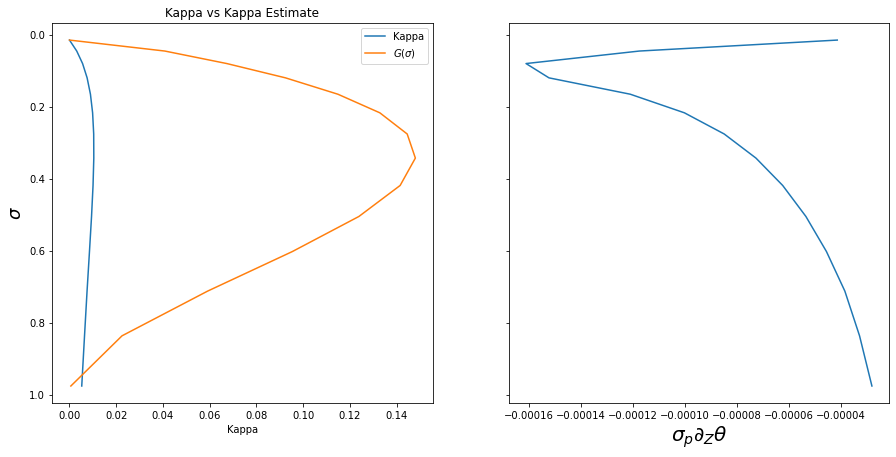

In [114]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,7))
timesel = 18
latsel = 10
lonsel = 10

kappasel = Kppdt.isel(time=timesel, lat=latsel, lon=lonsel).values
estsel = K.isel(time=timesel, lat=latsel, lon=lonsel).values
sigsel = sigma.isel(time=timesel,lat=latsel,lon=lonsel).values

zeroindex = np.where(sigsel == 0)[0][0]

kappa_trunc = kappasel[0:zeroindex]
est_trunc = estsel[0:zeroindex]
sig_trunc = sigsel[0:zeroindex]

ax1.plot(kappa_trunc, sig_trunc)
#ax1.plot(est_trunc, sig_trunc)

plt.gca().invert_yaxis()
ax1.set_ylabel(r"$\sigma$",size=18)
ax1.set_xlabel("Kappa")
ax1.set_title("Kappa vs Kappa Estimate")


sig_param = sigma_den_inf.isel(time=timesel, lat=latsel, lon=lonsel).values[0:zeroindex]
G_trunc = G.isel(time=timesel, lat=latsel, lon=lonsel).values[0:zeroindex]
dzT_trunc = dzT.isel(time=timesel, lat=latsel, lon=lonsel).values[0:zeroindex]
T_trunc = T.isel(time=timesel, lat=latsel, lon=lonsel).values[0:zeroindex]
ax2.plot( dzT_trunc * sig_param, sig_trunc)
#ax2.plot(T_trunc, sig_trunc)
#ax2.plot(G_trunc, sig_trunc)
ax2.set_xlabel(r"$\sigma_p \partial_Z \theta $", size=20)
#ax2.set_title("Parameterized Sigma")
ax1.plot(G_trunc, sig_trunc)
ax1.legend(['Kappa', r'$G(\sigma)$'])

In [115]:
dzT_x_vals =  dzT_trunc
dzT_x_linear_inv = np.arange( dzT_x_vals[0], dzT_x_vals[-1], ( dzT_x_vals[-1] - dzT_x_vals[0] ) / zeroindex)

In [116]:
dzT_x_linear_inv

array([-0.00290024, -0.00271307, -0.00252589, -0.00233872, -0.00215154,
       -0.00196437, -0.00177719, -0.00159002, -0.00140285, -0.00121567,
       -0.0010285 , -0.00084132, -0.00065415, -0.00046697])

In [117]:
( dzT[-1] - dzT[0] ) / zeroindex

<xarray.DataArray 'Theta' (depth: 30, lat: 786, lon: 980)>
array([[[-6.03208555e-04, -6.65152821e-04, -6.70182212e-04, ...,
         -1.09246003e-04, -6.04163502e-05,  2.36190368e-05],
        [-7.41357638e-04, -8.37298038e-04, -7.48997218e-04, ...,
         -1.27326344e-04, -1.17585879e-04, -8.29531131e-05],
        [-1.05044234e-03, -9.04399021e-04, -6.62287978e-04, ...,
         -1.34647609e-04, -1.32419398e-04, -1.26371396e-04],
        ...,
        [-1.56929719e-04, -1.66924837e-04, -2.00093350e-04, ...,
                     nan,             nan,             nan],
        [-1.62595741e-04, -1.89652589e-04, -2.29123756e-04, ...,
                     nan,             nan,             nan],
        [-1.73991449e-04, -2.16263795e-04, -3.43781129e-04, ...,
                     nan,             nan,             nan]],

       [[-5.02758121e-04, -5.66257254e-04, -5.79685411e-04, ...,
         -6.93149203e-05, -2.23773429e-05,  5.46388342e-05],
        [-6.44945663e-04, -7.50949662e-04, -6.76696284e-04, ...,
         -8.80523673e-05, -7.81409812e-05, -4.43238075e-05],
        [-9.70763772e-04, -8.39789276e-04, -5.95855404e-04, ...,
         -9.58922461e-05, -9.37659535e-05, -8.81697584e-05],
...
        [ 7.03783277e-05,  1.45312206e-05,  1.43800378e-05, ...,
                     nan,             nan,             nan],
        [ 1.79363336e-05, -2.03693558e-05,  2.39572972e-05, ...,
                     nan,             nan,             nan],
        [-3.40254226e-05, -7.51777143e-06,  8.61790728e-05, ...,
                     nan,             nan,             nan]],

       [[-4.56612708e-04, -3.16435666e-04, -1.37431776e-04, ...,
          5.86568508e-04,  4.42156290e-04,  1.90923167e-04],
        [-3.02646569e-04, -1.64260061e-04, -6.03396889e-05, ...,
          5.55706566e-04,  4.76705015e-04,  2.59508564e-04],
        [-1.46870073e-04, -5.53347818e-05, -3.43372968e-05, ...,
          4.46034680e-04,  3.96864358e-04,  2.41514023e-04],
        ...,
        [ 1.05367335e-05, -5.03942942e-05, -4.71072430e-05, ...,
                     nan,             nan,             nan],
        [-5.67900039e-05, -8.95448912e-05, -2.48758750e-05, ...,
                     nan,             nan,             nan],
        [-9.05243994e-05, -3.30158692e-05,  8.37950292e-05, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 171.8 189.9 209.2 229.9
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5

Interestingly enough, the derivative of theta is looking problematic. Also, Fig 7 is showing that the turbulent heat fluxes should be a profile in space. I need to find out how MITgcm calculates this . . .

In [118]:
wh = (qnet-qswc_1day) / (sigma_den_inf*rhoCp*dzT) # this is the velocity scale times height in the kappa equation from Large et al

what can we do about T? What kind of average are we supposed to do here? I would have to guess time...

In [119]:
Tavg = T.mean(dim='time')

In [120]:
dzTavg = Tavg.differentiate('depth')

In [121]:
Qavg = (qnet-qswc_1day).mean('time')

In [122]:
Knew = G * (Qavg) / (sigma_den_inf*rhoCp*dzTavg)# The -1 makes this work real nice

In [123]:
zeroindex = np.where(sigsel > 100)[0]

In [124]:
sigsel

array([0.01424404, 0.0447263 , 0.07948177, 0.11922265, 0.16466115,
       0.21636702, 0.27519494, 0.34214196, 0.41820514, 0.5043816 ,
       0.6018109 , 0.71191734, 0.8359829 , 0.9754322 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

timesel has to be 12 now since you've averaged over time

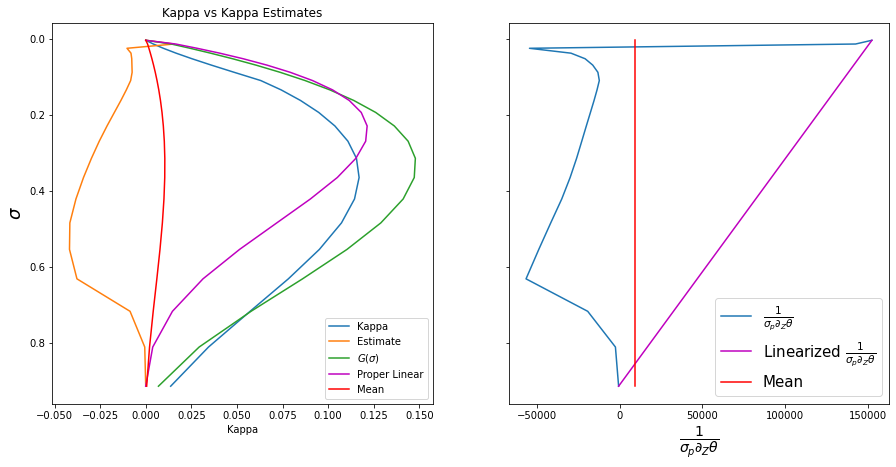

In [125]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,7))
timesel = 12
latsel = 392
lonsel = 7

kappasel = Kppdt.isel(time=timesel, lat=latsel, lon=lonsel).values
estsel = Knew.isel(time=timesel, lat=latsel, lon=lonsel).values
sigsel = sigma.isel(time=timesel,lat=latsel,lon=lonsel).values

zeroindex = np.where(sigsel == 0)[0][0]

kappa_trunc = kappasel[0:zeroindex]
est_trunc = estsel[0:zeroindex]
sig_trunc = sigsel[0:zeroindex]

ax1.plot(kappa_trunc, sig_trunc)


plt.gca().invert_yaxis()
ax1.set_ylabel(r"$\sigma$",size=18)
ax1.set_xlabel("Kappa")
ax1.set_title("Kappa vs Kappa Estimates")


sig_param = sigma_den_inf.isel(time=timesel, lat=latsel, lon=lonsel).values[0:zeroindex]
G_trunc = G.isel(time=timesel, lat=latsel, lon=lonsel).values[0:zeroindex]
Q_trunc = Qavg.isel(lat=latsel, lon=lonsel).values
dzT_trunc = dzTavg.isel( lat=latsel, lon=lonsel).values[0:zeroindex]
T_trunc = Tavg.isel( lat=latsel, lon=lonsel).values[0:zeroindex]
sigdzTinv =  1 / (dzT_trunc * sig_param)
m = (sigdzTinv[-1] - sigdzTinv[0]) / (sig_trunc[-1] - sig_trunc[0])
endpt_fit = m*(sig_trunc - np.full_like(sig_trunc, sig_trunc[0])) + np.full_like(sig_trunc, sigdzTinv[0])

mean = np.abs(np.full_like(sig_trunc, np.mean(sigdzTinv)))

ax2.plot( 1 / (dzT_trunc * sig_param), sig_trunc)
ax2.plot(endpt_fit, sig_trunc, 'm')
ax2.plot(mean, sig_trunc,'r')
#ax2.plot(T_trunc, sig_trunc)
#ax2.plot(G_trunc, sig_trunc)
ax2.set_xlabel(r"$\frac{1}{\sigma_p \partial_Z \theta} $", size=20)
#ax2.set_title("Parameterized Sigma")

ax1.plot(est_trunc, sig_trunc)
ax1.plot(G_trunc, sig_trunc)
ax1.plot(G_trunc * endpt_fit * Q_trunc / rhoCp, sig_trunc, 'm')
ax1.plot(G_trunc * mean * Q_trunc / rhoCp, sig_trunc, 'r')
ax1.legend(['Kappa','Estimate',r'$G(\sigma)$', 'Proper Linear', 'Mean'])
ax2.legend([r"$\frac{1}{\sigma_p \partial_Z \theta} $", r"Linearized $\frac{1}{\sigma_p \partial_Z \theta} $", "Mean"], fontsize = 15)

So the equation we're going for here is something like:

if $\epsilon < \sigma < 1$ $$K_x = \frac{G(\sigma) (Q_{net} - Q_{sw})}{\epsilon \rho C_p \partial_Z \theta}$$ and
if $\epsilon > \sigma < 1$ $$ K_x = \frac{G(\sigma) (Q_{net} - Q_{sw})}{\sigma\rho C_p \partial_Z \theta}$$ 
So let's load theta and calculate some derivatives

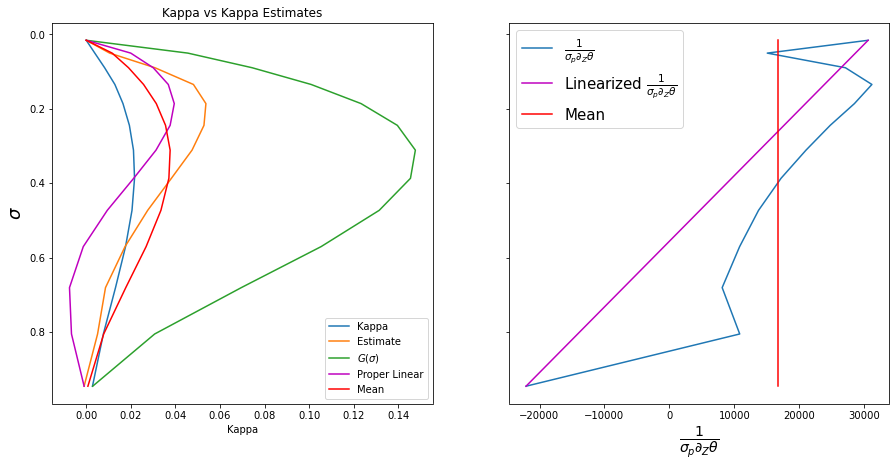

In [126]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,7))
timesel = 12
latsel = 320
lonsel = 202

kappasel = Kppdt.isel(time=timesel, lat=latsel, lon=lonsel).values
estsel = Knew.isel(time=timesel, lat=latsel, lon=lonsel).values
sigsel = sigma.isel(time=timesel,lat=latsel,lon=lonsel).values

zeroindex = np.where(sigsel == 0)[0][0]

kappa_trunc = kappasel[0:zeroindex]
est_trunc = estsel[0:zeroindex]
sig_trunc = sigsel[0:zeroindex]

ax1.plot(kappa_trunc, sig_trunc)


plt.gca().invert_yaxis()
ax1.set_ylabel(r"$\sigma$",size=18)
ax1.set_xlabel("Kappa")
ax1.set_title("Kappa vs Kappa Estimates")


sig_param = sigma_den_inf.isel(time=timesel, lat=latsel, lon=lonsel).values[0:zeroindex]
G_trunc = G.isel(time=timesel, lat=latsel, lon=lonsel).values[0:zeroindex]
Q_trunc = Qavg.isel(lat=latsel, lon=lonsel).values
dzT_trunc = dzTavg.isel( lat=latsel, lon=lonsel).values[0:zeroindex]
T_trunc = Tavg.isel( lat=latsel, lon=lonsel).values[0:zeroindex]
sigdzTinv =  1 / (dzT_trunc * sig_param)
m = (sigdzTinv[-1] - sigdzTinv[0]) / (sig_trunc[-1] - sig_trunc[0])
endpt_fit = m*(sig_trunc - np.full_like(sig_trunc, sig_trunc[0])) + np.full_like(sig_trunc, sigdzTinv[0])

mean = np.abs(np.full_like(sig_trunc, np.mean(sigdzTinv)))

ax2.plot( 1 / (dzT_trunc * sig_param), sig_trunc)
ax2.plot(endpt_fit, sig_trunc, 'm')
ax2.plot(mean, sig_trunc,'r')
#ax2.plot(T_trunc, sig_trunc)
#ax2.plot(G_trunc, sig_trunc)
ax2.set_xlabel(r"$\frac{1}{\sigma_p \partial_Z \theta} $", size=20)
#ax2.set_title("Parameterized Sigma")

ax1.plot(est_trunc, sig_trunc)
ax1.plot(G_trunc, sig_trunc)
ax1.plot(G_trunc * endpt_fit * Q_trunc / rhoCp, sig_trunc, 'm')
ax1.plot(G_trunc * mean * Q_trunc / rhoCp, sig_trunc, 'r')
ax1.legend(['Kappa','Estimate',r'$G(\sigma)$', 'Proper Linear', 'Mean'])
ax2.legend([r"$\frac{1}{\sigma_p \partial_Z \theta} $", r"Linearized $\frac{1}{\sigma_p \partial_Z \theta} $", "Mean"], fontsize = 15)

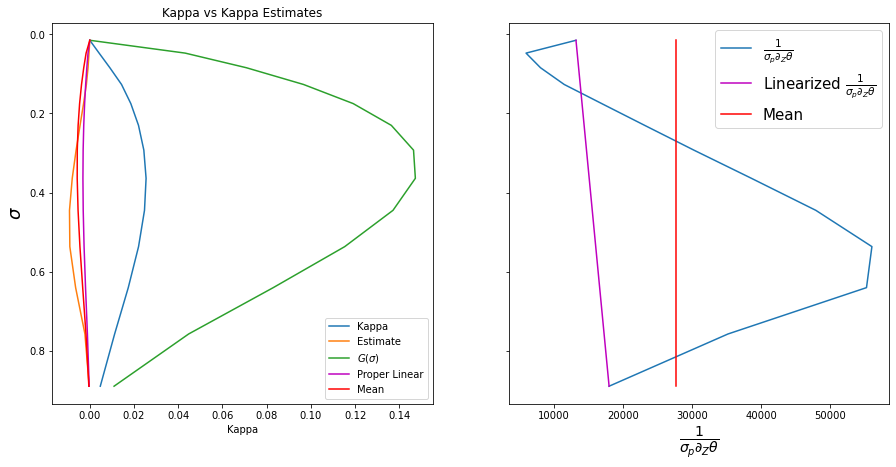

In [127]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,7))
timesel = 12
latsel = 708
lonsel = 382

kappasel = Kppdt.isel(time=timesel, lat=latsel, lon=lonsel).values
estsel = Knew.isel(time=timesel, lat=latsel, lon=lonsel).values
sigsel = sigma.isel(time=timesel,lat=latsel,lon=lonsel).values

zeroindex = np.where(sigsel == 0)[0][0]

kappa_trunc = kappasel[0:zeroindex]
est_trunc = estsel[0:zeroindex]
sig_trunc = sigsel[0:zeroindex]

ax1.plot(kappa_trunc, sig_trunc)


plt.gca().invert_yaxis()
ax1.set_ylabel(r"$\sigma$",size=18)
ax1.set_xlabel("Kappa")
ax1.set_title("Kappa vs Kappa Estimates")


sig_param = sigma_den_inf.isel(time=timesel, lat=latsel, lon=lonsel).values[0:zeroindex]
G_trunc = G.isel(time=timesel, lat=latsel, lon=lonsel).values[0:zeroindex]
Q_trunc = Qavg.isel(lat=latsel, lon=lonsel).values
dzT_trunc = dzTavg.isel( lat=latsel, lon=lonsel).values[0:zeroindex]
T_trunc = Tavg.isel( lat=latsel, lon=lonsel).values[0:zeroindex]
sigdzTinv =  1 / (dzT_trunc * sig_param)
m = (sigdzTinv[-1] - sigdzTinv[0]) / (sig_trunc[-1] - sig_trunc[0])
endpt_fit = m*(sig_trunc - np.full_like(sig_trunc, sig_trunc[0])) + np.full_like(sig_trunc, sigdzTinv[0])

mean = np.abs(np.full_like(sig_trunc, np.mean(sigdzTinv)))

ax2.plot( 1 / (dzT_trunc * sig_param), sig_trunc)
ax2.plot(endpt_fit, sig_trunc, 'm')
ax2.plot(mean, sig_trunc,'r')
#ax2.plot(T_trunc, sig_trunc)
#ax2.plot(G_trunc, sig_trunc)
ax2.set_xlabel(r"$\frac{1}{\sigma_p \partial_Z \theta} $", size=20)
#ax2.set_title("Parameterized Sigma")

ax1.plot(est_trunc, sig_trunc)
ax1.plot(G_trunc, sig_trunc)
ax1.plot(G_trunc * endpt_fit * Q_trunc / rhoCp, sig_trunc, 'm')
ax1.plot(G_trunc * mean * Q_trunc / rhoCp, sig_trunc, 'r')
ax1.legend(['Kappa','Estimate',r'$G(\sigma)$', 'Proper Linear', 'Mean'])
ax2.legend([r"$\frac{1}{\sigma_p \partial_Z \theta} $", r"Linearized $\frac{1}{\sigma_p \partial_Z \theta} $", "Mean"], fontsize = 15)

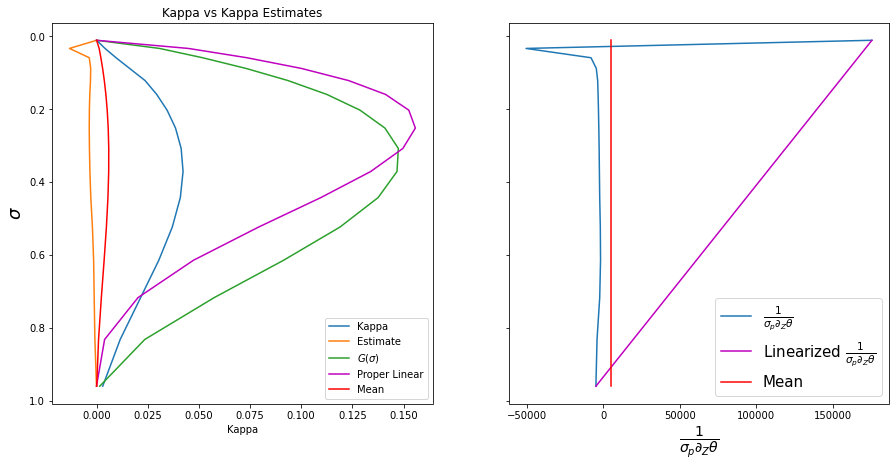

In [128]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,7))
timesel = 12
latsel = 10
lonsel = 402

kappasel = Kppdt.isel(time=timesel, lat=latsel, lon=lonsel).values
estsel = Knew.isel(time=timesel, lat=latsel, lon=lonsel).values
sigsel = sigma.isel(time=timesel,lat=latsel,lon=lonsel).values

zeroindex = np.where(sigsel == 0)[0][0]

kappa_trunc = kappasel[0:zeroindex]
est_trunc = estsel[0:zeroindex]
sig_trunc = sigsel[0:zeroindex]

ax1.plot(kappa_trunc, sig_trunc)


plt.gca().invert_yaxis()
ax1.set_ylabel(r"$\sigma$",size=18)
ax1.set_xlabel("Kappa")
ax1.set_title("Kappa vs Kappa Estimates")


sig_param = sigma_den_inf.isel(time=timesel, lat=latsel, lon=lonsel).values[0:zeroindex]
G_trunc = G.isel(time=timesel, lat=latsel, lon=lonsel).values[0:zeroindex]
Q_trunc = Qavg.isel(lat=latsel, lon=lonsel).values
dzT_trunc = dzTavg.isel( lat=latsel, lon=lonsel).values[0:zeroindex]
T_trunc = Tavg.isel( lat=latsel, lon=lonsel).values[0:zeroindex]
sigdzTinv =  1 / (dzT_trunc * sig_param)
m = (sigdzTinv[-1] - sigdzTinv[0]) / (sig_trunc[-1] - sig_trunc[0])
endpt_fit = m*(sig_trunc - np.full_like(sig_trunc, sig_trunc[0])) + np.full_like(sig_trunc, sigdzTinv[0])

mean = np.abs(np.full_like(sig_trunc, np.mean(sigdzTinv)))

ax2.plot( 1 / (dzT_trunc * sig_param), sig_trunc)
ax2.plot(endpt_fit, sig_trunc, 'm')
ax2.plot(mean, sig_trunc,'r')
#ax2.plot(T_trunc, sig_trunc)
#ax2.plot(G_trunc, sig_trunc)
ax2.set_xlabel(r"$\frac{1}{\sigma_p \partial_Z \theta} $", size=20)
#ax2.set_title("Parameterized Sigma")

ax1.plot(est_trunc, sig_trunc)
ax1.plot(G_trunc, sig_trunc)
ax1.plot(G_trunc * endpt_fit * Q_trunc / rhoCp, sig_trunc, 'm')
ax1.plot(G_trunc * mean * Q_trunc / rhoCp, sig_trunc, 'r')
ax1.legend(['Kappa','Estimate',r'$G(\sigma)$', 'Proper Linear', 'Mean'])
ax2.legend([r"$\frac{1}{\sigma_p \partial_Z \theta} $", r"Linearized $\frac{1}{\sigma_p \partial_Z \theta} $", "Mean"], fontsize = 15)

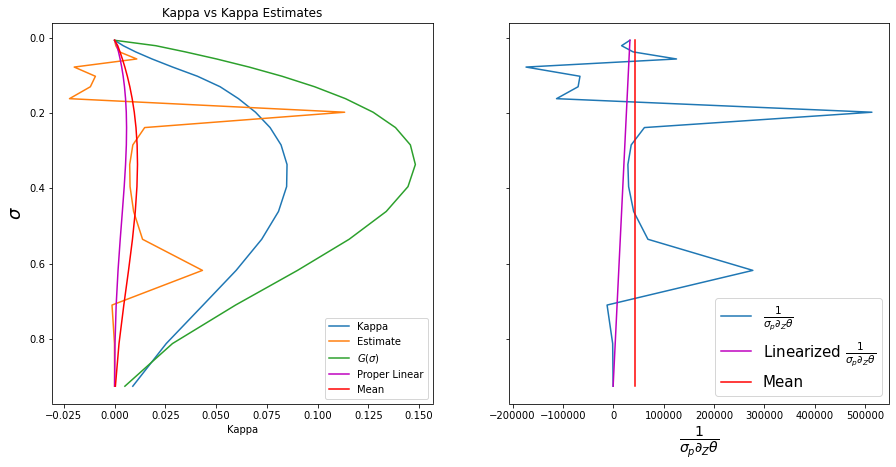

In [129]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,7))
timesel = 12
latsel = 100
lonsel = 402

kappasel = Kppdt.isel(time=timesel, lat=latsel, lon=lonsel).values
estsel = Knew.isel(time=timesel, lat=latsel, lon=lonsel).values
sigsel = sigma.isel(time=timesel,lat=latsel,lon=lonsel).values

zeroindex = np.where(sigsel == 0)[0][0]

kappa_trunc = kappasel[0:zeroindex]
est_trunc = estsel[0:zeroindex]
sig_trunc = sigsel[0:zeroindex]

ax1.plot(kappa_trunc, sig_trunc)


plt.gca().invert_yaxis()
ax1.set_ylabel(r"$\sigma$",size=18)
ax1.set_xlabel("Kappa")
ax1.set_title("Kappa vs Kappa Estimates")


sig_param = sigma_den_inf.isel(time=timesel, lat=latsel, lon=lonsel).values[0:zeroindex]
G_trunc = G.isel(time=timesel, lat=latsel, lon=lonsel).values[0:zeroindex]
Q_trunc = Qavg.isel(lat=latsel, lon=lonsel).values
dzT_trunc = dzTavg.isel( lat=latsel, lon=lonsel).values[0:zeroindex]
T_trunc = Tavg.isel( lat=latsel, lon=lonsel).values[0:zeroindex]
sigdzTinv =  1 / (dzT_trunc * sig_param)
m = (sigdzTinv[-1] - sigdzTinv[0]) / (sig_trunc[-1] - sig_trunc[0])
endpt_fit = m*(sig_trunc - np.full_like(sig_trunc, sig_trunc[0])) + np.full_like(sig_trunc, sigdzTinv[0])

mean = np.abs(np.full_like(sig_trunc, np.mean(sigdzTinv)))

ax2.plot( 1 / (dzT_trunc * sig_param), sig_trunc)
ax2.plot(endpt_fit, sig_trunc, 'm')
ax2.plot(mean, sig_trunc,'r')
#ax2.plot(T_trunc, sig_trunc)
#ax2.plot(G_trunc, sig_trunc)
ax2.set_xlabel(r"$\frac{1}{\sigma_p \partial_Z \theta} $", size=20)
#ax2.set_title("Parameterized Sigma")

ax1.plot(est_trunc, sig_trunc)
ax1.plot(G_trunc, sig_trunc)
ax1.plot(G_trunc * endpt_fit * Q_trunc / rhoCp, sig_trunc, 'm')
ax1.plot(G_trunc * mean * Q_trunc / rhoCp, sig_trunc, 'r')
ax1.legend(['Kappa','Estimate',r'$G(\sigma)$', 'Proper Linear', 'Mean'])
ax2.legend([r"$\frac{1}{\sigma_p \partial_Z \theta} $", r"Linearized $\frac{1}{\sigma_p \partial_Z \theta} $", "Mean"], fontsize = 15)

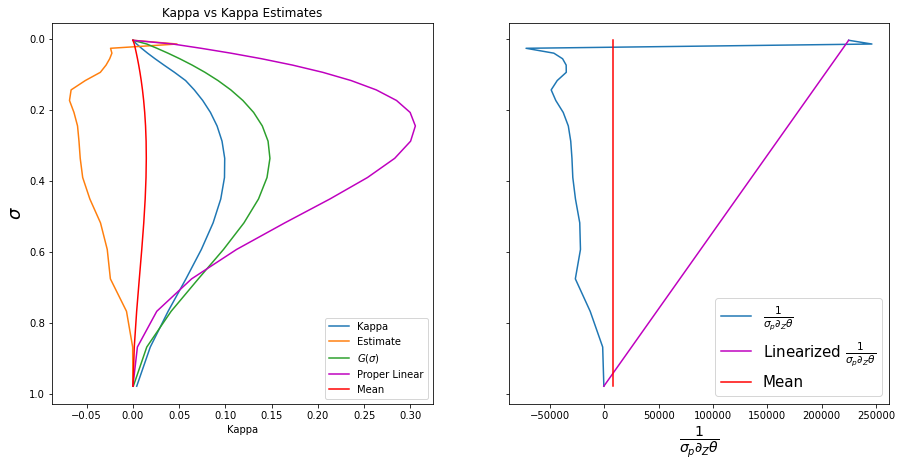

In [130]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,7))
timesel = 12
latsel = 10
lonsel = 42

kappasel = Kppdt.isel(time=timesel, lat=latsel, lon=lonsel).values
estsel = Knew.isel(time=timesel, lat=latsel, lon=lonsel).values
sigsel = sigma.isel(time=timesel,lat=latsel,lon=lonsel).values

zeroindex = np.where(sigsel == 0)[0][0]

kappa_trunc = kappasel[0:zeroindex]
est_trunc = estsel[0:zeroindex]
sig_trunc = sigsel[0:zeroindex]

ax1.plot(kappa_trunc, sig_trunc)


plt.gca().invert_yaxis()
ax1.set_ylabel(r"$\sigma$",size=18)
ax1.set_xlabel("Kappa")
ax1.set_title("Kappa vs Kappa Estimates")


sig_param = sigma_den_inf.isel(time=timesel, lat=latsel, lon=lonsel).values[0:zeroindex]
G_trunc = G.isel(time=timesel, lat=latsel, lon=lonsel).values[0:zeroindex]
Q_trunc = Qavg.isel(lat=latsel, lon=lonsel).values
dzT_trunc = dzTavg.isel( lat=latsel, lon=lonsel).values[0:zeroindex]
T_trunc = Tavg.isel( lat=latsel, lon=lonsel).values[0:zeroindex]
sigdzTinv =  1 / (dzT_trunc * sig_param)
m = (sigdzTinv[-1] - sigdzTinv[0]) / (sig_trunc[-1] - sig_trunc[0])
endpt_fit = m*(sig_trunc - np.full_like(sig_trunc, sig_trunc[0])) + np.full_like(sig_trunc, sigdzTinv[0])

mean = np.abs(np.full_like(sig_trunc, np.mean(sigdzTinv)))

ax2.plot( 1 / (dzT_trunc * sig_param), sig_trunc)
ax2.plot(endpt_fit, sig_trunc, 'm')
ax2.plot(mean, sig_trunc,'r')
#ax2.plot(T_trunc, sig_trunc)
#ax2.plot(G_trunc, sig_trunc)
ax2.set_xlabel(r"$\frac{1}{\sigma_p \partial_Z \theta} $", size=20)
#ax2.set_title("Parameterized Sigma")

ax1.plot(est_trunc, sig_trunc)
ax1.plot(G_trunc, sig_trunc)
ax1.plot(G_trunc * endpt_fit * Q_trunc / rhoCp, sig_trunc, 'm')
ax1.plot(G_trunc * mean * Q_trunc / rhoCp, sig_trunc, 'r')
ax1.legend(['Kappa','Estimate',r'$G(\sigma)$', 'Proper Linear', 'Mean'])
ax2.legend([r"$\frac{1}{\sigma_p \partial_Z \theta} $", r"Linearized $\frac{1}{\sigma_p \partial_Z \theta} $", "Mean"], fontsize = 15)

Now, I will focus on below the kpphbl. I don't have the correct $Q_{sw}$ and I'm not equipped to take derivatives the way the model does. 

03/29/2022: Let me deal with the Richardson number portion.

In [2]:
thk = scipy.io.loadmat('../Hector_Python_Scripts/thk90')
thickness = thk['thk90'][0,0:90]
depth = thk['dpt90'][0,0:90]
layer_min = 0
layer_max = 30

In [42]:
thickness[]

array([  1.  ,   1.14,   1.3 ,   1.49,   1.7 ,   1.93,   2.2 ,   2.5 ,
         2.84,   3.21,   3.63,   4.1 ,   4.61,   5.18,   5.79,   6.47,
         7.2 ,   7.98,   8.83,   9.73,  10.69,  11.7 ,  12.76,  13.87,
        15.03,  16.22,  17.45,  18.7 ,  19.97,  21.27,  22.56,  23.87,
        25.17,  26.46,  27.74,  29.  ,  30.24,  31.45,  32.65,  33.82,
        34.97,  36.09,  37.2 ,  38.29,  39.37,  40.45,  41.53,  42.62,
        43.73,  44.87,  46.05,  47.28,  48.56,  49.93,  51.38,  52.93,
        54.61,  56.42,  58.38,  60.53,  62.87,  65.43,  68.24,  71.33,
        74.73,  78.47,  82.61,  87.17,  92.21,  97.79, 103.96, 110.79,
       118.35, 126.73, 136.01, 146.3 , 157.71, 170.35, 184.37, 199.89,
       217.09, 236.13, 257.21, 280.5 , 306.24, 334.64, 365.93, 400.38,
       438.23, 479.74])

In [3]:
D = depth[layer_min+2:layer_max]-depth[layer_min:layer_max-2]
D = D[None,:, None,None]


In [50]:
depth[layer_min+2:layer_max]-depth[layer_min:layer_max-2]

array([ 2.29 ,  2.615,  2.99 ,  3.41 ,  3.88 ,  4.415,  5.02 ,  5.695,
        6.445,  7.285,  8.22 ,  9.25 , 10.38 , 11.615, 12.965, 14.425,
       15.995, 17.685, 19.49 , 21.405, 23.425, 25.545, 27.765, 30.075,
       32.46 , 34.91 , 37.41 , 39.955])

In [4]:
D.shape

(1, 28, 1, 1)

In [3]:
npdir = "/nobackup/amondal/NCData/Hector_CCS_Kappa/"
kpphbl = np.load(npdir + 'KPPhbl_test.npy')
latc = np.load(npdir + 'latc_test.npy')
lonc = np.load(npdir + 'lonc_test.npy')
u = np.load(npdir + 'U_test.npy')
v = np.load(npdir + 'V_test.npy')
t = np.load(npdir + 'T_test.npy')
s = np.load(npdir + 'Salt_test.npy')

In [4]:
lat_list = latc[:,0]
lon_list = lonc[0]
time_list = np.arange(0,u.shape[0])
depth_list = depth[0:u.shape[1]]

In [5]:
U = xr.DataArray(u, dims = ['time','Zlayers','lat','lon'], coords = {"time": time_list, "Zlayers": depth_list, "lat": lat_list, "lon":lon_list}, name = "U")
V = xr.DataArray(v, dims = ['time','Zlayers','lat','lon'], coords = {"time": time_list, "Zlayers": depth_list, "lat": lat_list, "lon":lon_list}, name = "V")
T = xr.DataArray(t, dims = ['time','Zlayers','lat','lon'], coords = {"time": time_list, "Zlayers": depth_list, "lat": lat_list, "lon":lon_list}, name = r"$\Theta$")
S = xr.DataArray(s, dims = ['time','Zlayers','lat','lon'], coords = {"time": time_list, "Zlayers": depth_list, "lat": lat_list, "lon":lon_list}, name = "Salt")

In [8]:
D.shape

(1, 28, 1, 1)

In [6]:
depth_tile = depth_list[None,:, None,None]
depth_tile = np.tile(depth_tile, (len(U.time), 1,len(U.lat),len(U.lon)))

In [56]:
depth_tile.shape
depth_tile_x = xr.DataArray(depth_tile, dims=["time","Zlayers","lat","lon"],  coords = { "time":U.time, "Zlayers": depth[layer_min:layer_max], "lat":U.lat, "lon":U.lon}, name="Depths")


In [8]:
D = np.tile(D,(len(U.time), 1,len(U.lat),len(U.lon)))

Dz = xr.DataArray(D, dims=["time","Zlayers","lat","lon"],  coords = { "time":U.time, "Zlayers": depth[layer_min+1:layer_max-1], "lat":U.lat, "lon":U.lon}, name="Centered Z Derivative of Depths")
Dz

<xarray.DataArray 'Centered Z Derivative of Depths' (time: 24, Zlayers: 28, lat: 786, lon: 980)>
array([[[[ 2.29 ,  2.29 ,  2.29 , ...,  2.29 ,  2.29 ,  2.29 ],
         [ 2.29 ,  2.29 ,  2.29 , ...,  2.29 ,  2.29 ,  2.29 ],
         [ 2.29 ,  2.29 ,  2.29 , ...,  2.29 ,  2.29 ,  2.29 ],
         ...,
         [ 2.29 ,  2.29 ,  2.29 , ...,  2.29 ,  2.29 ,  2.29 ],
         [ 2.29 ,  2.29 ,  2.29 , ...,  2.29 ,  2.29 ,  2.29 ],
         [ 2.29 ,  2.29 ,  2.29 , ...,  2.29 ,  2.29 ,  2.29 ]],

        [[ 2.615,  2.615,  2.615, ...,  2.615,  2.615,  2.615],
         [ 2.615,  2.615,  2.615, ...,  2.615,  2.615,  2.615],
         [ 2.615,  2.615,  2.615, ...,  2.615,  2.615,  2.615],
         ...,
         [ 2.615,  2.615,  2.615, ...,  2.615,  2.615,  2.615],
         [ 2.615,  2.615,  2.615, ...,  2.615,  2.615,  2.615],
         [ 2.615,  2.615,  2.615, ...,  2.615,  2.615,  2.615]],

        [[ 2.99 ,  2.99 ,  2.99 , ...,  2.99 ,  2.99 ,  2.99 ],
         [ 2.99 ,  2.99 ,  2.99 , ...,  2.99 ,  2.99 ,  2.99 ],
         [ 2.99 ,  2.99 ,  2.99 , ...,  2.99 ,  2.99 ,  2.99 ],
         ...,
...
         ...,
         [34.91 , 34.91 , 34.91 , ..., 34.91 , 34.91 , 34.91 ],
         [34.91 , 34.91 , 34.91 , ..., 34.91 , 34.91 , 34.91 ],
         [34.91 , 34.91 , 34.91 , ..., 34.91 , 34.91 , 34.91 ]],

        [[37.41 , 37.41 , 37.41 , ..., 37.41 , 37.41 , 37.41 ],
         [37.41 , 37.41 , 37.41 , ..., 37.41 , 37.41 , 37.41 ],
         [37.41 , 37.41 , 37.41 , ..., 37.41 , 37.41 , 37.41 ],
         ...,
         [37.41 , 37.41 , 37.41 , ..., 37.41 , 37.41 , 37.41 ],
         [37.41 , 37.41 , 37.41 , ..., 37.41 , 37.41 , 37.41 ],
         [37.41 , 37.41 , 37.41 , ..., 37.41 , 37.41 , 37.41 ]],

        [[39.955, 39.955, 39.955, ..., 39.955, 39.955, 39.955],
         [39.955, 39.955, 39.955, ..., 39.955, 39.955, 39.955],
         [39.955, 39.955, 39.955, ..., 39.955, 39.955, 39.955],
         ...,
         [39.955, 39.955, 39.955, ..., 39.955, 39.955, 39.955],
         [39.955, 39.955, 39.955, ..., 39.955, 39.955, 39.955],
         [39.955, 39.955, 39.955, ..., 39.955, 39.955, 39.955]]]])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * Zlayers  (Zlayers) float64 1.57 2.79 4.185 5.78 ... 155.0 171.8 189.9 209.2
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5

In [11]:
Up = U.shift(Zlayers=1, fill_value=0)
Um = U.shift(Zlayers=-1,fill_value=0)
Vp = V.shift(Zlayers=1, fill_value=0)
Vm = V.shift(Zlayers=-1,fill_value=0)

In [12]:
dU = (Up-Um).sel(Zlayers=U.Zlayers[1:-1])
dV = (Vp-Vm).sel(Zlayers=V.Zlayers[1:-1])
uz_t = dU / Dz
vz_t = dV / Dz
#fixed this!

In [13]:
shear = uz_t**2 + vz_t**2
shear.rename(r'$U_z^2 + V_z^2$')

<xarray.DataArray '$U_z^2 + V_z^2$' (time: 24, Zlayers: 28, lat: 786, lon: 980)>
array([[[[3.39879836e-04, 3.28406229e-04, 3.03327060e-04, ...,
          2.44034660e-04, 2.49164793e-04, 2.52623231e-04],
         [3.22394203e-04, 3.03433991e-04, 2.76266921e-04, ...,
          2.45762337e-04, 2.47883483e-04, 2.58530176e-04],
         [2.86983790e-04, 2.60319006e-04, 2.47684456e-04, ...,
          2.47091108e-04, 2.54280272e-04, 2.62082403e-04],
         ...,
         [4.72093596e-04, 4.74478434e-04, 4.74382723e-04, ...,
                     nan,            nan,            nan],
         [4.87508702e-04, 4.90061107e-04, 4.74624669e-04, ...,
                     nan,            nan,            nan],
         [5.00428070e-04, 4.93737639e-04, 4.75330070e-04, ...,
                     nan,            nan,            nan]],

        [[1.36585196e-04, 1.29371004e-04, 1.13447099e-04, ...,
          7.74892151e-05, 8.00893521e-05, 8.08747939e-05],
         [1.25090683e-04, 1.13228427e-04, 9.74760206e-05, ...,
          7.85833141e-05, 7.90160390e-05, 8.39604971e-05],
         [1.03220781e-04, 8.78264494e-05, 8.08536517e-05, ...,
          7.88746822e-05, 8.20202483e-05, 8.65094897e-05],
...
         [1.88287784e-06, 2.23825037e-06, 2.15699024e-06, ...,
                     nan,            nan,            nan],
         [2.27319648e-06, 2.64587430e-06, 2.56473229e-06, ...,
                     nan,            nan,            nan],
         [2.26908098e-06, 2.81614929e-06, 3.07416985e-06, ...,
                     nan,            nan,            nan]],

        [[1.98603306e-07, 9.00860401e-08, 1.61603211e-08, ...,
          1.38207126e-08, 3.10168729e-08, 2.16037208e-07],
         [1.98096493e-07, 8.92955315e-08, 2.19850598e-08, ...,
          7.43891345e-08, 9.33683236e-11, 5.73494730e-08],
         [1.40874463e-07, 7.25486742e-08, 1.89949427e-08, ...,
          2.84293578e-07, 1.05178992e-07, 1.00574102e-07],
         ...,
         [8.36443397e-07, 8.47618703e-07, 5.55695174e-07, ...,
                     nan,            nan,            nan],
         [1.16940850e-06, 1.08360366e-06, 7.27703308e-07, ...,
                     nan,            nan,            nan],
         [1.21027529e-06, 1.12692472e-06, 8.84115354e-07, ...,
                     nan,            nan,            nan]]]])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * Zlayers  (Zlayers) float64 1.57 2.79 4.185 5.78 ... 155.0 171.8 189.9 209.2
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5

In [14]:
depth_tile.shape

(24, 30, 786, 980)

In [10]:
# ##compute b at a given layer ##
import gsw
import dens # hector can give you this module if you need it

#latitude = 33
b = np.zeros(S.values.shape)

ref = 1027.5
P = gsw.p_from_z(-1*depth_tile[:,:,0, :], S.lat[0].values)
P = np.expand_dims(P, axis = 2)
for lati in range(1,len(S.lat)):
    pressure = gsw.p_from_z(-1*depth_tile[:, :, lati, :], S.lat[lati].values)
    pressure = np.expand_dims(pressure, axis = 2)
    P = np.concatenate((P, pressure), axis=2)
#pressure = gsw.p_from_z(-1*depth[layer_min:layer_max],33)


In [12]:
layer_max-layer_min

30

In [17]:
P[0,:,0,0]

array([  0.50368008,   1.58155958,   2.81055057,   4.21584024,
         5.82261689,   7.65103315,   9.73131712,  12.09873607,
        14.78855998,  17.8360621 ,  21.28155682,  25.17543819,
        29.56306929,  34.49485803,  40.02122118,  46.19762371,
        53.08458112,  60.73254736,  69.20206889,  78.55371138,
        88.84302332, 100.12557647, 112.45192893, 125.87266607,
       140.43840315, 156.18970675, 173.16213453, 191.38623528,
       210.88250671, 231.6765195 ])

In [16]:
P2 = np.concatenate((np.zeros(P[:,0:1,:,:].shape), P[:,0:-1,:,:]), axis=1)
P2[0,:,0,0]

array([  0.        ,   0.50368008,   1.58155958,   2.81055057,
         4.21584024,   5.82261689,   7.65103315,   9.73131712,
        12.09873607,  14.78855998,  17.8360621 ,  21.28155682,
        25.17543819,  29.56306929,  34.49485803,  40.02122118,
        46.19762371,  53.08458112,  60.73254736,  69.20206889,
        78.55371138,  88.84302332, 100.12557647, 112.45192893,
       125.87266607, 140.43840315, 156.18970675, 173.16213453,
       191.38623528, 210.88250671])

In [20]:
sig_test = np.zeros(S.values.shape)
rho_big = np.zeros(S.values.shape)
rho_pot_down = np.zeros(S.values.shape)
P2 = np.concatenate((np.zeros(P[:,0:1,:,:].shape), P[:,0:-1,:,:]), axis=1)
for layers in range(0,layer_max-layer_min):
    rho = dens.densjmd95(S[:,layers,:,:], T[:,layers,:,:], P[:, layers,:,:])
    rho_pot = dens.densjmd95(S[:,layers,:,:], T[:,layers,:,:], P2[:, layers,:,:])
# rho = dens.densjmd95(s_tot[layer,:,:],t_tot[layer,:,:],depth[layer]) # you can ask Hector the function dens.densjmd95 or use one that you like (e.g., from gsw)
    b[:,layers] = 9.81*(1-rho_pot/rho)
    #rho_big[:,layers] = rho
    #rho_pot_down[:,layers] = rho2

#here, b is not really defined fully yet. We need a few more derivatives

In [28]:
np.concatenate((np.zeros(P[:,0:1,:,:].shape), P[:,1:-1,:,:]), axis=1).shape

(24, 29, 786, 980)

In [22]:
B = xr.DataArray(b, dims=["time","Zlayers","lat","lon"],  coords = {"time":S.time, "Zlayers": depth[layer_min:layer_max],"lat":S.lat, "lon":S.lon}, name="Buoyancy")

In [72]:
dbloc = xr.concat((B[:,0:-1,:,:], xr.full_like(B[:,-1:,:,:],0)), "Zlayers")

In [73]:
dbloc[0,:,0,0]

<xarray.DataArray 'Buoyancy' (Zlayers: 30)>
array([2.15997991e-05, 4.62229190e-05, 5.27021004e-05, 6.02608791e-05,
       6.88990889e-05, 7.84005751e-05, 8.91970867e-05, 1.01504345e-04,
       1.15322317e-04, 1.30652563e-04, 1.47717355e-04, 1.66952812e-04,
       1.88142884e-04, 2.11510516e-04, 2.37053391e-04, 2.64973260e-04,
       2.95471295e-04, 3.28107492e-04, 3.63303986e-04, 4.01069504e-04,
       4.41216106e-04, 4.83927878e-04, 5.29178899e-04, 5.77046834e-04,
       6.27486122e-04, 6.79752202e-04, 7.33650927e-04, 7.88708512e-04,
       8.43882730e-04, 0.00000000e+00])
Coordinates:
    time     int64 0
  * Zlayers  (Zlayers) float64 0.5 1.57 2.79 4.185 ... 171.8 189.9 209.2 229.9
    lat      >f4 36.0
    lon      >f4 -127.6

In [17]:
#Bp = B.shift(Zlayers=1, fill_value=0)
#Bm = B.shift(Zlayers=-1,fill_value=0)
#Bp_t = B_t.shift(Zlayers=1, fill_value=0)
#Bm_t = B_t.shift(Zlayers=-1,fill_value=0)

In [18]:
#dB = (Bp-Bm).sel(Zlayers=B.Zlayers[1:-1])
#dB_t = (Bp_t-Bm_t).sel(Zlayers=B.Zlayers[1:-1])
#Bz_t = dB / Dz
#Bz_t.rename('dBouyancy / dz')

#Bz_test = dB_t / Dz
#Bz_test.rename('dBouyancy / dz with Potential density')
#fixed this!

<xarray.DataArray 'dBouyancy / dz with Potential density' (time: 24, Zlayers: 28, lat: 786, lon: 980)>
array([[[[9.43222667e-06, 9.43421504e-06, 9.43946781e-06, ...,
          9.41532340e-06, 9.41526683e-06, 9.41522776e-06],
         [9.43535583e-06, 9.44114078e-06, 9.45060592e-06, ...,
          9.41526096e-06, 9.41523844e-06, 9.41520253e-06],
         [9.44501143e-06, 9.45341938e-06, 9.46018877e-06, ...,
          9.41520878e-06, 9.41521429e-06, 9.41516707e-06],
         ...,
         [9.46236531e-06, 9.46307203e-06, 9.46345134e-06, ...,
                     nan,            nan,            nan],
         [9.46301878e-06, 9.46349003e-06, 9.46358392e-06, ...,
                     nan,            nan,            nan],
         [9.46335188e-06, 9.46365002e-06, 9.46370171e-06, ...,
                     nan,            nan,            nan]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan]]]])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * Zlayers  (Zlayers) float64 1.57 2.79 4.185 5.78 ... 155.0 171.8 189.9 209.2
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5

In [19]:
#b_z = (b[:-2,:,:]-b[2:,:,:])/D
#bz = b_z[:,1:-1,1:-1] - This is unnecessary because salinity and theta 
#b0 = b0[None,:]
#bz = np.vstack((b0,b_z)) #THIS SETS THE FIRST LAYER'S BUOYANCY GRADIENT TO BE 0 - WHICH DOES MAKE SENSE

#Bz_tshift = Bz_t.shift(Zlayers=1, fill_value = 0)
#this should effectively add a layer of zeroes at the top
#dB_0 = dB.shift(Zlayers=1,fill_value=0)
#dB_0.rename('Local Bouyancy Difference')


#Bz_2shift = Bz_test.shift(Zlayers=1, fill_value = 0)
#this should effectively add a layer of zeroes at the top
#dB_2 = dB.shift(Zlayers=1,fill_value=0)
#dB_2.rename('Local Bouyancy Difference')

<xarray.DataArray 'Local Bouyancy Difference' (time: 24, Zlayers: 28, lat: 786, lon: 980)>
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[1.00107572e-04, 9.95134359e-05, 1.00458025e-04, ...,
          8.88477435e-05, 8.90955019e-05, 8.90872324e-05],
         [9.83357504e-05, 9.81833801e-05, 1.01388838e-04, ...,
          8.90787627e-05, 8.93076287e-05, 8.91462244e-05],
         [9.59528753e-05, 9.96676803e-05, 1.04208082e-04, ...,
          8.94420933e-05, 8.92976296e-05, 8.87665375e-05],
...
         [4.45008959e-03, 4.46701422e-03, 4.37362998e-03, ...,
                     nan,            nan,            nan],
         [4.64938620e-03, 4.64331384e-03, 4.51058022e-03, ...,
                     nan,            nan,            nan],
         [4.80893577e-03, 4.79374418e-03, 4.70624414e-03, ...,
                     nan,            nan,            nan]],

        [[3.15578648e-03, 3.10891020e-03, 3.06025859e-03, ...,
          1.74451440e-03, 1.75594705e-03, 1.79191365e-03],
         [3.16896677e-03, 3.12254210e-03, 3.06661567e-03, ...,
          1.75619726e-03, 1.76210113e-03, 1.77919083e-03],
         [3.18887105e-03, 3.13256527e-03, 3.06634804e-03, ...,
          1.78194177e-03, 1.78279908e-03, 1.79326648e-03],
         ...,
         [2.89995069e-03, 2.94948060e-03, 2.96481892e-03, ...,
                     nan,            nan,            nan],
         [2.98657430e-03, 3.02733617e-03, 3.00983347e-03, ...,
                     nan,            nan,            nan],
         [3.01424686e-03, 3.06026198e-03, 3.05419484e-03, ...,
                     nan,            nan,            nan]]]])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * Zlayers  (Zlayers) float64 1.57 2.79 4.185 5.78 ... 155.0 171.8 189.9 209.2
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5

In [ ]:
dB_0[:,27,:,:]

----------------------------------------------------------------------------------------------------------------------------------------------------

Effectively copying Joe's code

In [67]:
thk = scipy.io.loadmat('../Hector_Python_Scripts/thk90')
thickness = thk['thk90'][0,0:90]
depth = thk['dpt90'][0,0:90]
layer_min = 20
layer_max = 30

In [68]:
depth[layer_min+2:layer_max]-depth[layer_min:layer_max-2]

array([23.425, 25.545, 27.765, 30.075, 32.46 , 34.91 , 37.41 , 39.955])

In [69]:
oldnpdir = "/nobackup/amondal/NCData/Hector_CCS_Kappa/"
npdir = "/nobackup/amondal/NCData/20220425_diagnostic_vars_SNAPS/"
kpphbl = np.load(npdir + 'KPPhbl_test.npy')
latc = np.load(oldnpdir + 'latc_test.npy')
lonc = np.load(oldnpdir + 'lonc_test.npy')
u = np.load(npdir + 'UVEL_test.npy')
v = np.load(npdir + 'VVEL_test.npy')
t = np.load(npdir + 'THETA_test.npy')
s = np.load(npdir + 'SALT_test.npy')

# TAKING ONLY 1 TIMESTEP


In [70]:
#taking only 1 timestep
u = u[0:1]
v = v[0:1]
t = t[0:1]
s = s[0:1]

In [71]:
lat_list = latc[:,0]
lon_list = lonc[0]
time_list = np.arange(0,u.shape[0])
depth_list = depth[layer_min:layer_max]

In [72]:
depth_list

array([ 88.175,  99.37 , 111.6  , 124.915, 139.365, 154.99 , 171.825,
       189.9  , 209.235, 229.855])

In [73]:
U = xr.DataArray(u[:,layer_min:layer_max], dims = ['time','Zlayers','lat','lon'], coords = {"time": time_list, "Zlayers": depth_list, "lat": lat_list, "lon":lon_list}, name = "U")
V = xr.DataArray(v[:,layer_min:layer_max], dims = ['time','Zlayers','lat','lon'], coords = {"time": time_list, "Zlayers": depth_list, "lat": lat_list, "lon":lon_list}, name = "V")
T = xr.DataArray(t[:,layer_min:layer_max], dims = ['time','Zlayers','lat','lon'], coords = {"time": time_list, "Zlayers": depth_list, "lat": lat_list, "lon":lon_list}, name = r"$\Theta$")
S = xr.DataArray(s[:,layer_min:layer_max], dims = ['time','Zlayers','lat','lon'], coords = {"time": time_list, "Zlayers": depth_list, "lat": lat_list, "lon":lon_list}, name = "Salt")

In [74]:
U.shape

(1, 10, 786, 980)

In [75]:
depth_tile = depth_list[None,:, None,None]
depth_tile = np.tile(depth_tile, (len(U.time), 1,len(U.lat),len(U.lon)))

In [76]:
sys.path.append("//nobackup//amondal//Python//Joes_kpp_code//12_16_21//")
import fld_tools as ft
Uval = np.swapaxes(np.swapaxes(U.values, 0,3),1,2)
Vval = np.swapaxes(np.swapaxes(V.values, 0,3),1,2)
shsq_Joe = ft.get_shsq(Uval,Vval)
print('Shear calculated')

Shear calculated


In [77]:
shsq_swap = np.swapaxes(np.swapaxes(shsq_Joe, 0, 3),1,2)
shsq_long = xr.DataArray(shsq_swap, dims = U.dims, coords = U.coords)
shsq = shsq_long[:,0:-1]
print('Shear truncated')
#I'm truncating the first element in height because I need to calculate pot_rho_down and that requires a shift.

Shear truncated


In [78]:
# check ft.get_dzgrid() -- this is the thickness between adjacent tracer points
dzgrid = depth[layer_min+1:layer_max+1] - depth[layer_min:layer_max]
dzgrid = dzgrid[None,:,None,None]
dzgrid = np.tile(dzgrid,(len(U.time), 1,len(U.lat),len(U.lon)))
dzgrid = xr.DataArray(dzgrid, dims = U.dims, coords = U.coords, name='Distances between Tracers')
print('Dzgrid - this is the distance between tracers')

Dzgrid - this is the distance between tracers


In [79]:
#I'm trying out Joe's way to calculate pressure
#JOE MENTIONED THAT THIS IS AN APPROXIMATION AND NOT HOW THE MODEL CALCULATES PRESSURE
rho0 = 1035
g = 9.81
p_joe = depth * g * rho0 / 10000 + 10
p_joe_concat = p_joe[20:30]
pjoe = p_joe_concat[None,:,None,None]
pjoe = np.tile(pjoe, (len(U.time), 1, len(U.lat), len(U.lon)))
#Pjoe = xr.DataArray(Pjoe, dims = U.dims, coords = U.coords)

In [80]:
#this let's you calculate energy using latitude and the gsw code

# comment this out until you've confirmed that Joe's pressure doesn't work

"""
import gsw
import dens # hector can give you this module if you need it

#latitude = 33
b = np.zeros(S.values.shape)

ref = 1027.5
P = gsw.p_from_z(-1*depth_tile[:,:,0, :], S.lat[0].values)
P = np.expand_dims(P, axis = 2)
for lati in range(1,len(S.lat)):
    pressure = gsw.p_from_z(-1*depth_tile[:, :, lati, :], S.lat[lati].values)
    pressure = np.expand_dims(pressure, axis = 2)
    P = np.concatenate((P, pressure), axis=2)
#pressure = gsw.p_from_z(-1*depth[layer_min:layer_max],33)

for layers in range(0,layer_max-layer_min-1):
    rho = gsw.rho(SA[:,layers,:,:], CT[:,layers,:,:], Pjoe0[:, layers,:,:])#dens.densjmd95(S[:,layers,:,:], T[:,layers,:,:], P[:, layers,:,:])
    rho_pot = gsw.rho(SA[:,layers,:,:], CT[:,layers,:,:], Pjoe_down[:, layers,:,:])#dens.densjmd95(S[:,layers,:,:], T[:,layers,:,:], P2[:, layers,:,:])
# rho = dens.densjmd95(s_tot[layer,:,:],t_tot[layer,:,:],depth[layer]) # you can ask Hector the function dens.densjmd95 or use one that you like (e.g., from gsw)
    b[:,layers] = 9.81*(1-rho_pot/rho)
    #rho_big[:,layers] = rho
    #rho_pot_down[:,layers] = rho2

"""

'\nimport gsw\nimport dens # hector can give you this module if you need it\n\n#latitude = 33\nb = np.zeros(S.values.shape)\n\nref = 1027.5\nP = gsw.p_from_z(-1*depth_tile[:,:,0, :], S.lat[0].values)\nP = np.expand_dims(P, axis = 2)\nfor lati in range(1,len(S.lat)):\n    pressure = gsw.p_from_z(-1*depth_tile[:, :, lati, :], S.lat[lati].values)\n    pressure = np.expand_dims(pressure, axis = 2)\n    P = np.concatenate((P, pressure), axis=2)\n#pressure = gsw.p_from_z(-1*depth[layer_min:layer_max],33)\n\nfor layers in range(0,layer_max-layer_min-1):\n    rho = gsw.rho(SA[:,layers,:,:], CT[:,layers,:,:], Pjoe0[:, layers,:,:])#dens.densjmd95(S[:,layers,:,:], T[:,layers,:,:], P[:, layers,:,:])\n    rho_pot = gsw.rho(SA[:,layers,:,:], CT[:,layers,:,:], Pjoe_down[:, layers,:,:])#dens.densjmd95(S[:,layers,:,:], T[:,layers,:,:], P2[:, layers,:,:])\n# rho = dens.densjmd95(s_tot[layer,:,:],t_tot[layer,:,:],depth[layer]) # you can ask Hector the function dens.densjmd95 or use one that you like (e.g

Joe doesn't have his density vary as a function of latitude. We need to check if MITgcm gives reason for this.
My calculation varies from his by about 10 dbar. 

Next up, fix the rho and rho_pot calculation below



In [81]:
#preps for calculating rho and pot_rho_down
import gsw
#gsw.SA_from_SP(S, layers, S.lon, S.lat)
SP = S.values
PT = T.values
lon = S.lon
lat = S.lat

SP = np.swapaxes(SP, 2,3)
PT = np.swapaxes(PT, 2,3)
#pjoe0 = np.swapaxes(pjoe0,2,3)
#pjoe_down = np.swapaxes(pjoe_down,2,3)
pjoe_swap = np.swapaxes(pjoe,2,3)

In [82]:
PT.shape

(1, 10, 980, 786)

In [83]:
(nt, nz, nx, ny) = SP.shape
SA = np.zeros([nt, nz, nx, ny])
SA_down = np.zeros([nt, nz, nx, ny])
CT = np.zeros([nt, nz, nx, ny])
CT_down = np.zeros([nt, nz, nx, ny])
rho = np.zeros([nt,nz,nx, ny])
pot_rho_down = np.zeros([nt,nz,nx, ny])


for t in range(0,nt):
    for k in range(0,nz-1):
        SA[t,k,:,:] = gsw.SA_from_SP(SP[t,k,:,:], pjoe_swap[t,k,:,:], lon, lat)
        SA_down[t,k,:,:] = gsw.SA_from_SP(SP[t,k,:,:], pjoe_swap[t,k+1,:,:], lon, lat)
        CT[t,k,:,:] = gsw.CT_from_t(SA[t,k,:,:], PT[t,k,:,:], pjoe_swap[t,k,:,:])
        CT_down[t,k,:,:] = gsw.CT_from_t(SA[t,k,:,:], PT[t,k,:,:], pjoe_swap[t,k+1,:,:])
        rho[t,k,:,:] = gsw.rho(SA[t,k,:,:], CT[t,k,:,:], pjoe_swap[t,k ,:,:])
        pot_rho_down[t,k,:,:] = gsw.rho(SA_down[t,k,:,:], CT_down[t,k,:,:], pjoe_swap[t,k,:,:])
    
#You've tried to swithc k's to double check joe's analysis 

In [84]:
rho[:, :, 50,50]

array([[1025.53343157, 1025.70554298, 1025.99659725, 1026.39198714,
        1026.80093769, 1027.11447799, 1027.27620452, 1027.36860718,
        1027.45908711,    0.        ]])

In [85]:
pot_rho_down[:,:,50,50]

array([[1025.53387907, 1025.70602853, 1025.99716767, 1026.39259455,
        1026.80157051, 1027.11513307, 1027.27688966, 1027.3692997 ,
        1027.45982712,    0.        ]])

In [86]:
#b = g*(1-pot_rho_down[:,0:-2,:,:] / rho[:,1:-1,:,:])
#Joe's code
# there's a nuance I didn't notice with the rho[z+1]
#dbloc = glb.g*(rho[gx0:gxn,gy0:gyn,gz0+1:gzn+1,:] - pot_rho_down[gx0:gxn,gy0:gyn,gz0:gzn,:])/(rho[gx0:gxn,gy0:gyn,gz0+1:gzn+1,:]);

#in kpp_routines.F, (RHOK(i,j) - RHOKM1(i,j)) / (RHOK(i,j) + rhoConst)

In [126]:
pot_rho_down_test = pot_rho_down[:, 0:-2]
rho_test = rho[:,1:-1]
b_test = g*(1-pot_rho_down_test / rho_test)

#I ADDED A ONE TO EXPERIMENT

In [127]:
b_swapdim = np.swapaxes(b_test,2,3)

In [128]:
B = xr.DataArray(b_swapdim, dims=["time","Zlayers","lat","lon"],  coords = {"time":S.time, "Zlayers": depth[layer_min:layer_max-2],"lat":S.lat, "lon":S.lon}, name="Buoyancy")

In [129]:
dbloc = xr.concat((B[:,0:-1,:,:], xr.full_like(B[:,-1:,:,:],0)), "Zlayers")
#YOU NEED TO DOUBLE CHECK WHY THIS MIGHT BE NECESSARY

In [130]:
diffus2 = dbloc / dzgrid

In [131]:
dblocSm = ft.smooth_horiz(dbloc)

In [132]:
dblocSm = xr.DataArray(dblocSm, dims = dbloc.dims, coords = dbloc.coords)

In [133]:
nu0 = 50e-4#50e-4 m^2/s
Riinfty = 0.6998 
p1 = 3
#constants that are relevant

Horizontal Smoothing - how do we do this?

In [134]:
diffus = dblocSm*dzgrid/ xr.ufuncs.maximum(shsq, 1e-10)

In [166]:
BVSQcon = -2e-5
Rig   = xr.ufuncs.maximum(diffus2, BVSQcon);
ratio = xr.ufuncs.minimum((BVSQcon-Rig)/BVSQcon, 1.0);
fcon  = 1.0 - ratio*ratio;
fcon  = fcon*fcon*fcon;

In [167]:
Rig

<xarray.DataArray (time: 1, Zlayers: 8, lat: 786, lon: 980)>
array([[[[2.53945017e-04, 2.51901088e-04, 2.45681795e-04, ...,
          1.81319009e-04, 1.92385485e-04, 1.93548554e-04],
         [2.49520489e-04, 2.48786828e-04, 2.45626560e-04, ...,
          1.87695013e-04, 1.95744725e-04, 1.98058818e-04],
         [2.45645759e-04, 2.45539044e-04, 2.45618483e-04, ...,
          1.81744182e-04, 1.90496895e-04, 1.98787084e-04],
         ...,
         [6.59346931e-05, 6.46888850e-05, 6.32728069e-05, ...,
                     nan,            nan,            nan],
         [6.41658236e-05, 6.28911225e-05, 6.17946475e-05, ...,
                     nan,            nan,            nan],
         [6.12999552e-05, 6.02490130e-05, 5.94412507e-05, ...,
                     nan,            nan,            nan]],

        [[2.59257909e-04, 2.60889043e-04, 2.62096185e-04, ...,
          2.47995495e-04, 2.45209569e-04, 2.41299433e-04],
         [2.65979991e-04, 2.66932935e-04, 2.68897699e-04, ...,
          2.44330421e-04, 2.44049433e-04, 2.40819299e-04],
         [2.75039238e-04, 2.74515306e-04, 2.73216751e-04, ...,
          2.33078622e-04, 2.38914454e-04, 2.36661374e-04],
...
         [1.41649042e-04, 1.51147771e-04, 1.58346636e-04, ...,
                     nan,            nan,            nan],
         [1.47953737e-04, 1.57606345e-04, 1.63751999e-04, ...,
                     nan,            nan,            nan],
         [1.55047104e-04, 1.61383472e-04, 1.65263245e-04, ...,
                     nan,            nan,            nan]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]])
Coordinates:
  * Zlayers  (Zlayers) float64 88.17 99.37 111.6 124.9 139.4 155.0 171.8 189.9
  * time     (time) int64 0
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5

In [136]:
Rig  = xr.ufuncs.maximum(diffus, 0.0);
ratio = xr.ufuncs.minimum(Rig/Riinfty, 1.0);
fRi   = 1.0 - ratio*ratio;
fRi   = fRi*fRi*fRi;

Now add on the stuff you need to get diffusivity, specifically, thermal

 difm0   = 5. _d -3
      difs0   = 5. _d -3
      dift0   = 5. _d -3

      difmcon = 0.1 _d 0
      difscon = 0.1 _d 0
      diftcon = 0.1 _d 0
      
       viscAr= 5.6614e-04,
 diffKrT=5.44e-7,

In [137]:
diffusKrT = 5.43999988e-07
viscAr = 5.6614e-04
diftcon = 0.1
dift0 = 5e-3
diffusKzT = diffusKrT + fcon*diftcon + fRi*dift0
kviscA = viscAr + fcon*diftcon + fRi*dift0

In [138]:
1e-1

0.1

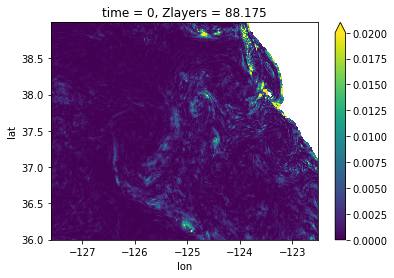

In [139]:
%matplotlib inline
shsq[0,0,:,:].plot(vmin=0, vmax=0.02)

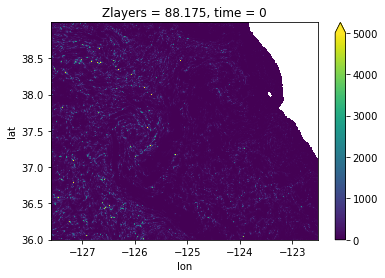

In [140]:
%matplotlib inline
diffus[0,0,:,:].plot(vmin=0, vmax=5000)

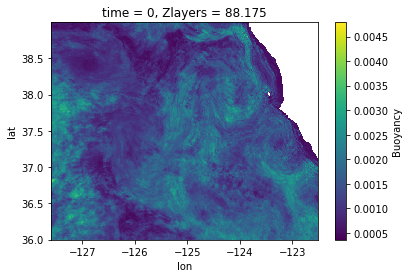

In [141]:
%matplotlib inline
B[0,0,:,:].plot()

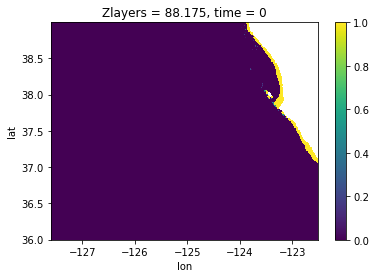

In [142]:
%matplotlib inline
fRi[0,0,:,:].plot()

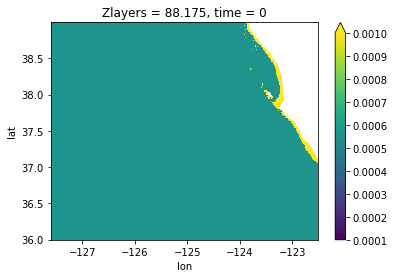

In [143]:
%matplotlib inline
#diffusKzT[0, 0, :,:].plot(vmin=1e-5, vmax=1e-4)
kviscA[0,0,:,:].plot(vmin=1e-4, vmax=1e-3)

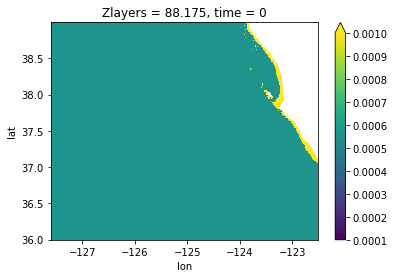

In [39]:
%matplotlib inline
#diffusKzT[0, 0, :,:].plot(vmin=1e-5, vmax=1e-4)
kviscA[0,0,:,:].plot(vmin=1e-4, vmax=1e-3)

In [40]:
npdir = "/nobackup/amondal/NCData/20220425_diagnostic_vars_SNAPS/"
kppviscA = np.load(npdir + 'KPPviscA_test.npy')

In [41]:
KppviscA = xr.DataArray(kppviscA[time_list,20:28], dims = B.dims, coords = B.coords)

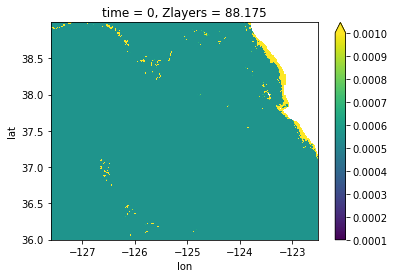

In [42]:
%matplotlib inline
KppviscA[0,0,:,:].plot(vmin=1e-4, vmax=1e-3)#diffusKzT[0:10, 0, :,:].plot(col = "time", col_wrap = 5, vmin=1e-5, vmax=1e-4)

In [43]:
npdir = "/nobackup/amondal/NCData/Hector_CCS_Kappa/"
kppdt= np.load(npdir + 'KPPdiffT_test.npy')

In [44]:
kppdt.shape

(24, 30, 786, 980)

In [45]:
Kppdt = xr.DataArray(kppdt[time_list,20:28], dims = B.dims, coords = B.coords)

In [46]:
Hbl = xr.DataArray(kpphbl,dims =('time','lat','lon'))

In [47]:
diffusKzT[0,0]

<xarray.DataArray (lat: 786, lon: 980)>
array([[5.43999988e-07, 5.43999988e-07, 5.43999988e-07, ...,
                   nan,            nan,            nan],
       [5.43999988e-07, 5.43999988e-07, 5.43999988e-07, ...,
        5.43999988e-07, 5.43999988e-07, 5.43999988e-07],
       [5.43999988e-07, 5.43999988e-07, 5.43999988e-07, ...,
        5.43999988e-07, 5.43999988e-07, 5.43999988e-07],
       ...,
       [           nan, 5.43999988e-07, 5.43999988e-07, ...,
                   nan,            nan,            nan],
       [           nan, 5.43999988e-07, 5.43999988e-07, ...,
                   nan,            nan,            nan],
       [           nan, 5.43999988e-07, 5.43999988e-07, ...,
                   nan,            nan,            nan]])
Coordinates:
    Zlayers  float64 88.17
    time     int64 0
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5

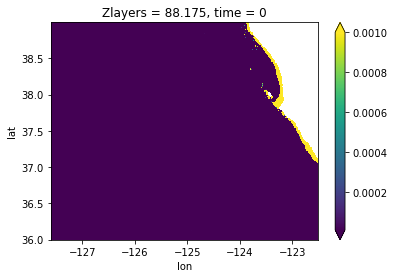

In [48]:
%matplotlib inline
diffusKzT[0,0,:,:].plot(vmin=1e-5, vmax=1e-3)#diffusKzT[0:10, 0, :,:].plot(col = "time", col_wrap = 5, vmin=1e-5, vmax=1e-4)

In [51]:
visc_ratio = kviscA / KppviscA
visc_ratio_inv = KppviscA / kviscA

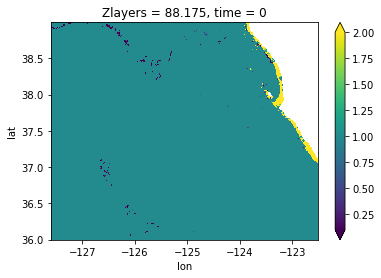

In [52]:
%matplotlib inline
visc_ratio[0,0,:,:].plot(vmin=0.1,vmax=2)

In [144]:
npdir = "/nobackup/amondal/NCData/20220425_diagnostic_vars_SNAPS/"
kppviscA = np.load(npdir + 'KPPviscA_test.npy')

In [145]:
KppviscA = xr.DataArray(kppviscA[time_list,20:28], dims = B.dims, coords = B.coords)

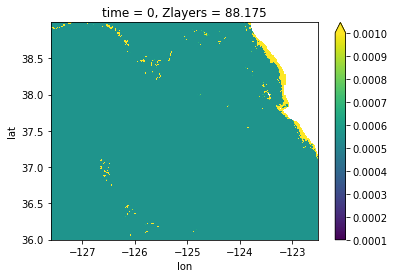

In [146]:
%matplotlib inline
KppviscA[0,0,:,:].plot(vmin=1e-4, vmax=1e-3)#diffusKzT[0:10, 0, :,:].plot(col = "time", col_wrap = 5, vmin=1e-5, vmax=1e-4)

In [147]:
npdir = "/nobackup/amondal/NCData/Hector_CCS_Kappa/"
kppdt= np.load(npdir + 'KPPdiffT_test.npy')

In [148]:
kppdt.shape

(24, 30, 786, 980)

In [149]:
Kppdt = xr.DataArray(kppdt[time_list,20:28], dims = B.dims, coords = B.coords)

In [150]:
Hbl = xr.DataArray(kpphbl,dims =('time','lat','lon'))

In [151]:
diffusKzT[0,0]

<xarray.DataArray (lat: 786, lon: 980)>
array([[5.43999988e-07, 5.43999988e-07, 5.43999988e-07, ...,
                   nan,            nan,            nan],
       [5.43999988e-07, 5.43999988e-07, 5.43999988e-07, ...,
        5.43999988e-07, 5.43999988e-07, 5.43999988e-07],
       [5.43999988e-07, 5.43999988e-07, 5.43999988e-07, ...,
        5.43999988e-07, 5.43999988e-07, 5.43999988e-07],
       ...,
       [           nan, 5.43999988e-07, 5.43999988e-07, ...,
                   nan,            nan,            nan],
       [           nan, 5.43999988e-07, 5.43999988e-07, ...,
                   nan,            nan,            nan],
       [           nan, 5.43999988e-07, 5.43999988e-07, ...,
                   nan,            nan,            nan]])
Coordinates:
    Zlayers  float64 88.17
    time     int64 0
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5

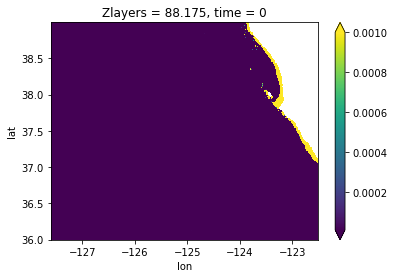

In [152]:
%matplotlib inline
diffusKzT[0,0,:,:].plot(vmin=1e-5, vmax=1e-3)#diffusKzT[0:10, 0, :,:].plot(col = "time", col_wrap = 5, vmin=1e-5, vmax=1e-4)

In [153]:
visc_ratio = kviscA / KppviscA
visc_ratio_inv = KppviscA / kviscA

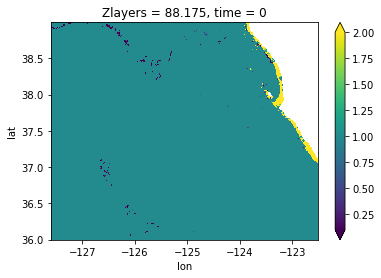

In [154]:
%matplotlib inline
visc_ratio[0,0,:,:].plot(vmin=0.1,vmax=2)

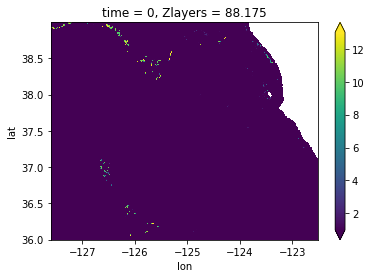

In [155]:
%matplotlib inline
visc_ratio_inv[0,0,:,:].plot(vmin=1, vmax=13)

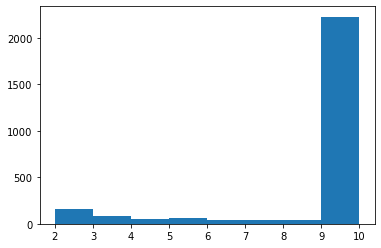

In [156]:
%matplotlib inline
histo_visc_ratio = visc_ratio[0,1].values.flatten()
x = plt.hist(histo_visc_ratio, bins = [2,3,4,5,6,7,8,9,10])

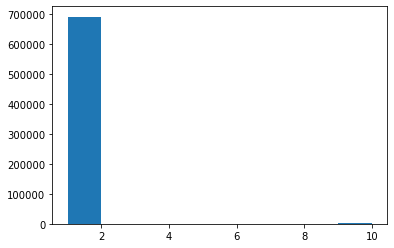

In [157]:
y = x = plt.hist(histo_visc_ratio, bins = [1,2,3,4,5,6,7,8,9,10])

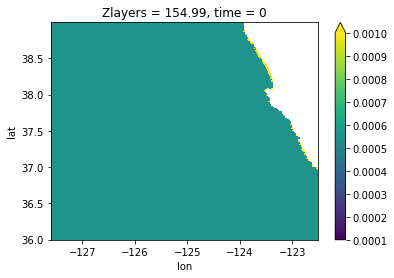

In [158]:
%matplotlib inline
#diffusKzT[0, 0, :,:].plot(vmin=1e-5, vmax=1e-4)
kviscA[0,5,:,:].plot(vmin=1e-4, vmax=1e-3)

In [159]:
npdir = "/nobackup/amondal/NCData/20220425_diagnostic_vars_SNAPS/"
kppviscA = np.load(npdir + 'KPPviscA_test.npy')

In [160]:
KppviscA = xr.DataArray(kppviscA[time_list,20:28], dims = B.dims, coords = B.coords)

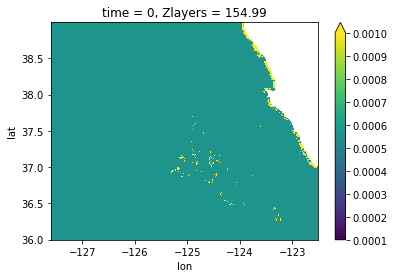

In [161]:
%matplotlib inline
KppviscA[0,5,:,:].plot(vmin=1e-4, vmax=1e-3)#diffusKzT[0:10, 0, :,:].plot(col = "time", col_wrap = 5, vmin=1e-5, vmax=1e-4)

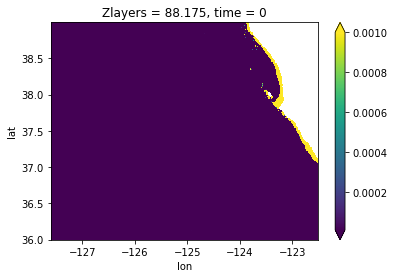

In [162]:
%matplotlib inline
diffusKzT[0,0,:,:].plot(vmin=1e-5, vmax=1e-3)#diffusKzT[0:10, 0, :,:].plot(col = "time", col_wrap = 5, vmin=1e-5, vmax=1e-4)

In [163]:
visc_ratio = kviscA / KppviscA
visc_ratio_inv = KppviscA / kviscA

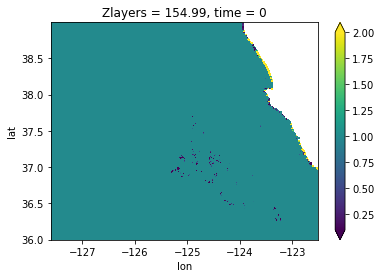

In [164]:
%matplotlib inline
visc_ratio[0,5,:,:].plot(vmin=0.1,vmax=2)

In [165]:
visc_ratio

<xarray.DataArray (time: 1, Zlayers: 8, lat: 786, lon: 980)>
array([[[[1.00000001, 1.00000001, 1.00000001, ...,        nan,
                 nan,        nan],
         [1.00000001, 1.00000001, 1.00000001, ..., 1.00000001,
          1.00000001, 1.00000001],
         [1.00000001, 1.00000001, 1.00000001, ..., 1.00000001,
          1.00000001, 1.00000001],
         ...,
         [       nan, 1.00000001, 1.00000001, ...,        nan,
                 nan,        nan],
         [       nan, 1.00000001, 1.00000001, ...,        nan,
                 nan,        nan],
         [       nan, 1.00000001, 1.00000001, ...,        nan,
                 nan,        nan]],

        [[1.00000001, 1.00000001, 1.00000001, ...,        nan,
                 nan,        nan],
         [1.00000001, 1.00000001, 1.00000001, ..., 1.00000001,
          1.00000001, 1.00000001],
         [1.00000001, 1.00000001, 1.00000001, ..., 1.00000001,
          1.00000001, 1.00000001],
...
         [       nan, 1.00000001, 1.00000001, ...,        nan,
                 nan,        nan],
         [       nan, 1.00000001, 1.00000001, ...,        nan,
                 nan,        nan],
         [       nan, 1.00000001, 1.00000001, ...,        nan,
                 nan,        nan]],

        [[1.00000001, 1.00000001, 1.00000001, ...,        nan,
                 nan,        nan],
         [1.00000001, 1.00000001, 1.00000001, ..., 1.00000001,
          1.00000001, 1.00000001],
         [1.00000001, 1.00000001, 1.00000001, ..., 1.00000001,
          1.00000001, 1.00000001],
         ...,
         [       nan, 1.00000001, 1.00000001, ...,        nan,
                 nan,        nan],
         [       nan, 1.00000001, 1.00000001, ...,        nan,
                 nan,        nan],
         [       nan, 9.83173787, 9.83173787, ...,        nan,
                 nan,        nan]]]])
Coordinates:
  * Zlayers  (Zlayers) float64 88.17 99.37 111.6 124.9 139.4 155.0 171.8 189.9
  * time     (time) int64 0
  * lat      (lat) >f4 36.0 36.0 36.01 36.01 36.01 ... 38.98 38.99 38.99 38.99
  * lon      (lon) >f4 -127.6 -127.6 -127.6 -127.6 ... -122.5 -122.5 -122.5